In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import re
import sys
import cv2
import shutil
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import subprocess
import h5py
import time

from datetime import timedelta
from io import BytesIO
from tqdm import tqdm
from pathlib import Path
from PIL import Image
from dataclasses import dataclass
from IPython.display import clear_output
from joblib import dump, load

# Preprocessing and EDA
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score, roc_curve, roc_auc_score
from sklearn.utils import resample

## Feature-scaling stack
from sklearn.preprocessing import RobustScaler, OneHotEncoder, FunctionTransformer

## Dimesionality reduction
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

# Deep learning modeling
import tensorflow as tf
from tensorflow.keras.layers import RandomRotation
from tensorflow import keras
#from tensorflow_addons.utils.types import TensorLike
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, PrecisionAtRecall, SpecificityAtSensitivity
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.mixed_precision import set_global_policy

from keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint
from keras.initializers import glorot_uniform
from keras.models import load_model, Model

## Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTEENN

# Machine learning modeling
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, StackingClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

## Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score, auc, fbeta_score, f1_score

import warnings
warnings.filterwarnings('ignore')

#set_global_policy('mixed_float16')
set_global_policy('float32')
#set_global_policy('mixed_float16')

In [3]:
# Check for available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detected: {gpus}")
else:
    print("No GPU detected.")

GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


### **Note: GPU execution is recommended for this notebook**

# 1. Models and Constants

Pretrained models can be downloaded from this link: https://drive.google.com/drive/folders/1WUwwZfYQLRqRyH0z22ZfiXWt3Nzj37zd

In [4]:
# Check out files
imputer_age_model =         '/kaggle/input/imputers/other/default/1/imputer_age.joblib'
imputer_sex_model =         '/kaggle/input/imputers/other/default/1/imputer_sex.joblib'
imputer_numerical_model =   '/kaggle/input/imputers/other/default/1/imputer_numericals.joblib'
imputer_categorical_model = '/kaggle/input/imputers/other/default/1/imputer_categoricals.joblib'
crossval_preds =            '/kaggle/input/train-cnn-crossval-preds-rn152v2-v2/train-cnn-crossval-preds-rn152v2_v2.csv'
#crossval_preds =            '/kaggle/input/train-cnn-crossval-preds-rn152v2-v4/train-cnn-crossval-preds-rn152v2_v4.csv'
rn152v2_weights =           '/kaggle/input/resnet152v2/keras/default/1/resnet152v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
cnn_weights =               '/kaggle/input/resnet152v2-kaggle-1-default-v4/keras/default/1/rn152v2_nn64_lr0001_relu_batch64_epoch50_kaggle_weights_2.h5'
ml_model =                  '/kaggle/input/soft-voting-classifier-v2/scikitlearn/default/1/soft_voting_classif_xgb_lgb_gbm.joblib'

try:
    with open(imputer_age_model, 'r') as file:
        print(f"The file {imputer_age_model} is accessible.")
except FileNotFoundError:
    print(f"The file {imputer_age_model} was not found.")
except Exception as e:
    print(f"An error occurred while trying to access the file: {e}")

try:
    with open(imputer_sex_model, 'r') as file:
        print(f"The file {imputer_sex_model} is accessible.")
except FileNotFoundError:
    print(f"The file {imputer_sex_model} was not found.")
except Exception as e:
    print(f"An error occurred while trying to access the file: {e}")

try:
    with open(imputer_numerical_model, 'r') as file:
        print(f"The file {imputer_numerical_model} is accessible.")
except FileNotFoundError:
    print(f"The file {imputer_numerical_model} was not found.")
except Exception as e:
    print(f"An error occurred while trying to access the file: {e}")

try:
    with open(imputer_categorical_model, 'r') as file:
        print(f"The file {imputer_categorical_model} is accessible.")
except FileNotFoundError:
    print(f"The file {imputer_categorical_model} was not found.")
except Exception as e:
    print(f"An error occurred while trying to access the file: {e}")
    
try:
    with open(crossval_preds, 'r') as file:
        print(f"The file {crossval_preds} is accessible.")
except FileNotFoundError:
    print(f"The file {crossval_preds} was not found.")
except Exception as e:
    print(f"An error occurred while trying to access the file: {e}")

try:
    with open(rn152v2_weights, 'r') as file:
        print(f"The file {rn152v2_weights} is accessible.")
except FileNotFoundError:
    print(f"The file {rn152v2_weights} was not found.")
except Exception as e:
    print(f"An error occurred while trying to access the file: {e}")
    
try:
    with open(cnn_weights, 'r') as file:
        print(f"The file {cnn_weights} is accessible.")
except FileNotFoundError:
    print(f"The file {cnn_weights} was not found.")
except Exception as e:
    print(f"An error occurred while trying to access the file: {e}")
    
try:
    with open(ml_model, 'r') as file:
        print(f"The file {ml_model} is accessible.")
except FileNotFoundError:
    print(f"The file {ml_model} was not found.")
except Exception as e:
    print(f"An error occurred while trying to access the file: {e}")

The file /kaggle/input/imputers/other/default/1/imputer_age.joblib is accessible.
The file /kaggle/input/imputers/other/default/1/imputer_sex.joblib is accessible.
The file /kaggle/input/imputers/other/default/1/imputer_numericals.joblib is accessible.
The file /kaggle/input/imputers/other/default/1/imputer_categoricals.joblib is accessible.
The file /kaggle/input/train-cnn-crossval-preds-rn152v2-v2/train-cnn-crossval-preds-rn152v2_v2.csv is accessible.
The file /kaggle/input/resnet152v2/keras/default/1/resnet152v2_weights_tf_dim_ordering_tf_kernels_notop.h5 is accessible.
The file /kaggle/input/resnet152v2-kaggle-1-default-v4/keras/default/1/rn152v2_nn64_lr0001_relu_batch64_epoch50_kaggle_weights_2.h5 is accessible.
The file /kaggle/input/soft-voting-classifier-v2/scikitlearn/default/1/soft_voting_classif_xgb_lgb_gbm.joblib is accessible.


In [5]:
ENABLE = {
    'eda':         1,
    'fe-dt':       1,
    'train-cnn':   1,
    'load-cnn-bk': 1,
    'train-ml':    1,
    'inference':   1,
    'profiling':   1
}

RUN_ON_KAGGLE = 1

if RUN_ON_KAGGLE == 1:
    ROOT_DATASET_DIR = "/kaggle/input"
else:
    ROOT_DATASET_DIR = "../"

# Convert from seconds to hhmmss
def hhmmss(seconds):
    td = timedelta(seconds=seconds)
    return str(td)

# 1. Exploratory Data Analysis (EDA)

## Dataframe Loading

In [6]:
if ENABLE['profiling'] == 1:
    start_total = time.time()
    start = start_total

if ENABLE['eda'] == 1:
    # Read the dataset
    IMAGE_PATH = os.path.join(ROOT_DATASET_DIR,"isic-2024-challenge","train-image","image")
    file_name_train = os.path.join(ROOT_DATASET_DIR,"isic-2024-challenge","train-metadata.csv")
    df_raw_train = pd.read_csv(file_name_train)

## Feature Analysis

In [7]:
# Apply head
if ENABLE['eda'] == 1:
    display(df_raw_train.head(5))

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [8]:
# Appli describe
if ENABLE['eda'] == 1:
    stats = df_raw_train.describe().T.head()
    display(stats)

,count,mean,std,min,25%,50%,75%,max
target,401059.0,0.000980,0.031288,0.000000,0.000000,0.00000,0.000000,1.00000
age_approx,398261.0,58.012986,13.596165,5.000000,50.000000,60.00000,70.000000,85.00000
clin_size_long_diam_mm,401059.0,3.930827,1.743068,1.000000,2.840000,3.37000,4.380000,28.40000
tbp_lv_A,401059.0,19.974007,3.999489,-2.487115,17.330821,19.80191,22.304628,48.18961
tbp_lv_Aext,401059.0,14.919247,3.529384,-9.080269,12.469740,14.71393,17.137175,37.02168


In [9]:
# Check out the number of samples in the dataframe
if ENABLE['eda'] == 1:
    print(f"Number of samples in the training dataframe: {df_raw_train.shape[0]}")
    print(f"Number of features in the training dataframe: {df_raw_train.shape[1]}")

Number of samples in the training dataframe: 401059
Number of features in the training dataframe: 55


In [10]:
# Check out the data types
if ENABLE['eda'] == 1:
    display(df_raw_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

None

## Imbalance Analysis

target
0    400666
1       393
Name: count, dtype: int64


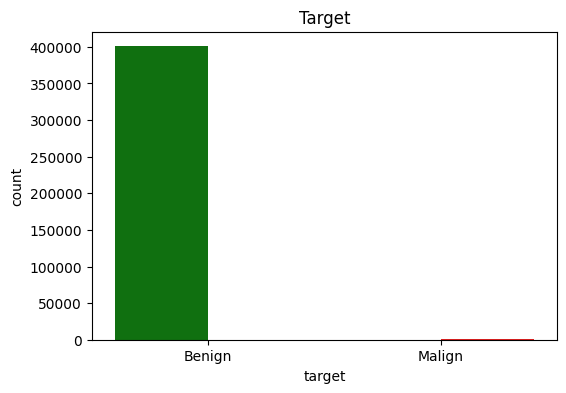

In [11]:
if ENABLE['eda'] == 1:

    targets = df_raw_train.target.value_counts()
    print(targets)
    
    fig, ax = plt.subplots(figsize=(6,4))
    plt.title('Target')
    sns.countplot(data=df_raw_train, x='target', hue='target', palette=['green', 'red'], ax=ax)
    ax.legend_.remove()
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Benign', 'Malign'])
    plt.show()

The database is extremely imbalanced. There are much more benign cases than malign cases.

## Removing Irrelevant Features

In [12]:
if ENABLE['eda'] == 1:
    # Features that are not included in the test dataset
    columns_to_be_dropped_train = ['lesion_id','iddx_full','iddx_1','iddx_2','iddx_3','iddx_4','iddx_5','mel_mitotic_index','mel_thick_mm','tbp_lv_dnn_lesion_confidence','patient_id','image_type','attribution','copyright_license']
    df_dropped_train = df_raw_train.drop(columns=columns_to_be_dropped_train)

In [13]:
# Function to print NaN values only
def print_NaNs(df):
    nan_list = df.isna().sum()
    if nan_list.sum() == 0:
        print("The dataframe contains no NaN values")
    else:
        return nan_list[nan_list != 0]

if ENABLE['eda'] == 1:
    print('Train: ', end='', flush=True)
    display(print_NaNs(df_dropped_train))

Train: 

age_approx              2798
sex                    11517
anatom_site_general     5756
dtype: int64

In [14]:
df_dropped_train.columns.tolist()

['isic_id',
 'target',
 'age_approx',
 'sex',
 'anatom_site_general',
 'clin_size_long_diam_mm',
 'tbp_tile_type',
 'tbp_lv_A',
 'tbp_lv_Aext',
 'tbp_lv_B',
 'tbp_lv_Bext',
 'tbp_lv_C',
 'tbp_lv_Cext',
 'tbp_lv_H',
 'tbp_lv_Hext',
 'tbp_lv_L',
 'tbp_lv_Lext',
 'tbp_lv_areaMM2',
 'tbp_lv_area_perim_ratio',
 'tbp_lv_color_std_mean',
 'tbp_lv_deltaA',
 'tbp_lv_deltaB',
 'tbp_lv_deltaL',
 'tbp_lv_deltaLB',
 'tbp_lv_deltaLBnorm',
 'tbp_lv_eccentricity',
 'tbp_lv_location',
 'tbp_lv_location_simple',
 'tbp_lv_minorAxisMM',
 'tbp_lv_nevi_confidence',
 'tbp_lv_norm_border',
 'tbp_lv_norm_color',
 'tbp_lv_perimeterMM',
 'tbp_lv_radial_color_std_max',
 'tbp_lv_stdL',
 'tbp_lv_stdLExt',
 'tbp_lv_symm_2axis',
 'tbp_lv_symm_2axis_angle',
 'tbp_lv_x',
 'tbp_lv_y',
 'tbp_lv_z']

## Removing NaN Values

Given the high number of benign cases, it would be possible simple to remove those raws with at least one NaN value. Howerve, it would also remove some malign cases. Due to the very low number of malign cases, it would be preferable to keep them. In such a case, we can replace the NaN values of ages with the median, thos of sex with the mode, and those of anatom_site_general can be removed as it is very difficult to estimate the region of the cancer.

In [15]:
# In the below code we will generate two imputing models to complete missing information in the "age_approx" and "sex" fields.
if ENABLE['eda'] == 1:
    
    # Replace and remove NaN values
    IMPUTER_AGE = KNNImputer(n_neighbors=5)
    age_approx_reshaped_train = df_dropped_train[['age_approx']]
    df_dropped_train['age_approx'] = IMPUTER_AGE.fit_transform(age_approx_reshaped_train)
    IMPUTER_SEX = KNNImputer(n_neighbors=5)
    df_dropped_train['sex'] = df_dropped_train['sex'].apply(lambda x: 0 if x == 'male' else 1 if x == 'female' else np.NaN)
    sex_reshaped_train = df_dropped_train[['sex']]
    df_dropped_train['sex'] = IMPUTER_SEX.fit_transform(sex_reshaped_train)
    df_dropped_train.dropna(subset=['anatom_site_general'], inplace=True)
    print_NaNs(df_dropped_train)

    # Determine how many cases have been removed
    print(f"Number of samples before removing NaNs: {df_raw_train.shape[0]}")
    print(f"Number of samples after removing NaNs:  {df_dropped_train.shape[0]}")
    print(f"Data reduccion in percentage: {np.round(100 * (df_dropped_train.shape[0] - df_raw_train.shape[0]) / df_raw_train.shape[0], 1)}%")

    targets_dropped = df_dropped_train.target.value_counts()
    print(f"Targets before dropping:")
    print(targets)
    print(f"Targets after dropping:")
    print(targets_dropped)
    
    # Save imputers
    #imputer_age_model = 'imputer_age.joblib'
    #imputer_sex_model = 'imputer_sex.joblib'
    #dump(IMPUTER_AGE, imputer_age_model)
    #dump(IMPUTER_SEX, imputer_sex_model)

The dataframe contains no NaN values
Number of samples before removing NaNs: 401059
Number of samples after removing NaNs:  395303
Data reduccion in percentage: -1.4%
Targets before dropping:
target
0    400666
1       393
Name: count, dtype: int64
Targets after dropping:
target
0    394910
1       393
Name: count, dtype: int64


## Converting Data Types

In [16]:
if ENABLE['eda'] == 1:
    
    # Convert target, sex, and tile_type into boolean (or int with 0 and 1) and others to categorical

    # target
    df_dropped_train['target'] = df_dropped_train['target'].astype(int)

    # tdb_tile_type -> 0: white, 1: XP
    df_dropped_train['tbp_tile_type'] = df_dropped_train['tbp_tile_type'].apply(lambda x: 0 if x == '3D: white' else 1)
    df_dropped_train['tbp_tile_type'] = df_dropped_train['tbp_tile_type'].astype(int)

    # Convert anatom_site_general, tbp_lv_location, tbp_lv_location_simple, and sex into categorical
    df_dropped_train['anatom_site_general'] = pd.Categorical(df_dropped_train['anatom_site_general'])
    df_dropped_train['tbp_lv_location'] = pd.Categorical(df_dropped_train['tbp_lv_location'])
    df_dropped_train['tbp_lv_location_simple'] = pd.Categorical(df_dropped_train['tbp_lv_location_simple'])
    df_dropped_train['sex'] = pd.Categorical(df_dropped_train['sex'])
    print(df_dropped_train.dtypes)

isic_id                          object
target                            int64
age_approx                      float64
sex                            category
anatom_site_general            category
clin_size_long_diam_mm          float64
tbp_tile_type                     int64
tbp_lv_A                        float64
tbp_lv_Aext                     float64
tbp_lv_B                        float64
tbp_lv_Bext                     float64
tbp_lv_C                        float64
tbp_lv_Cext                     float64
tbp_lv_H                        float64
tbp_lv_Hext                     float64
tbp_lv_L                        float64
tbp_lv_Lext                     float64
tbp_lv_areaMM2                  float64
tbp_lv_area_perim_ratio         float64
tbp_lv_color_std_mean           float64
tbp_lv_deltaA                   float64
tbp_lv_deltaB                   float64
tbp_lv_deltaL                   float64
tbp_lv_deltaLB                  float64
tbp_lv_deltaLBnorm              float64


### Data Distribution Analysis: Skewness Correction

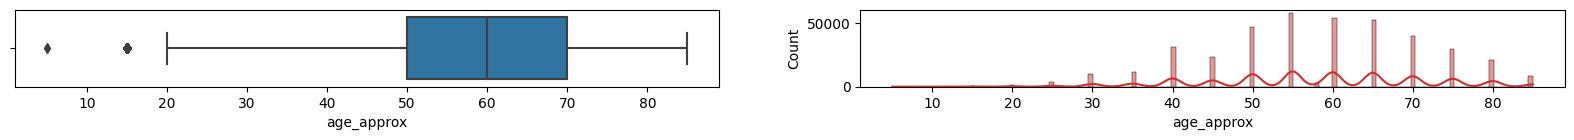

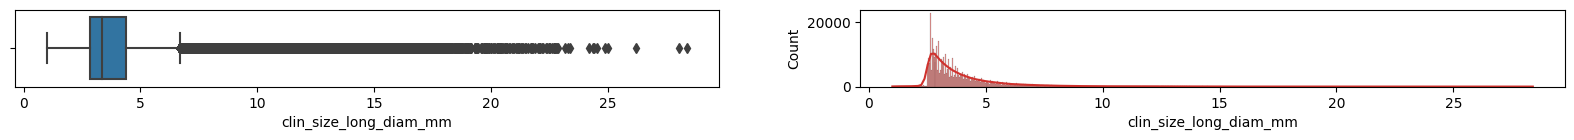

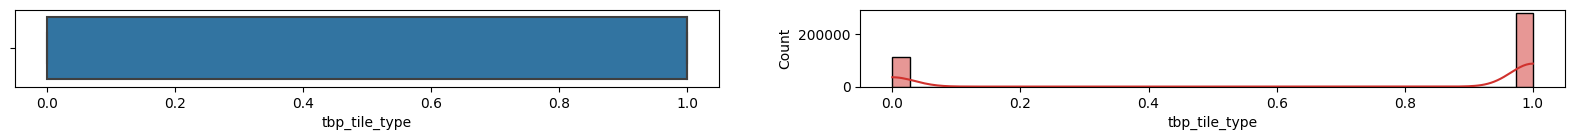

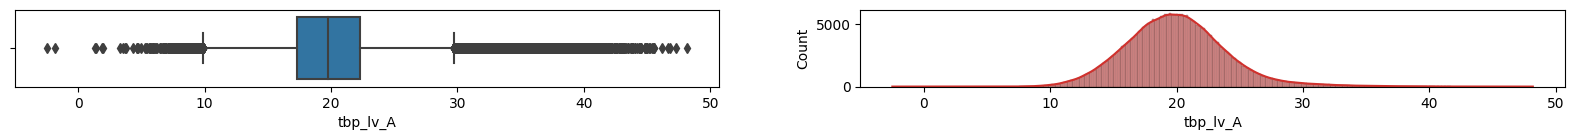

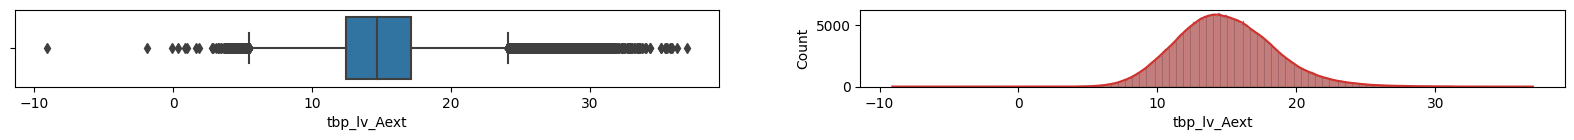

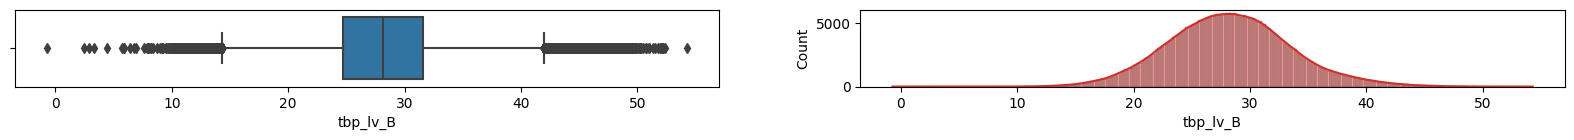

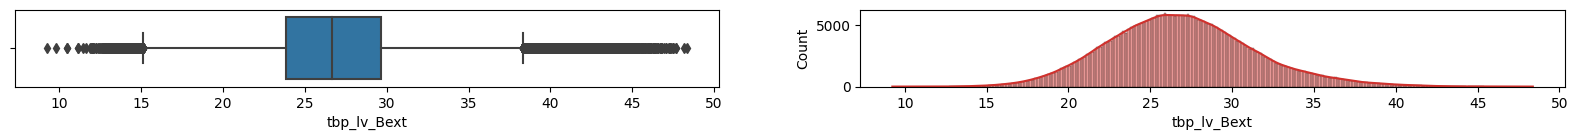

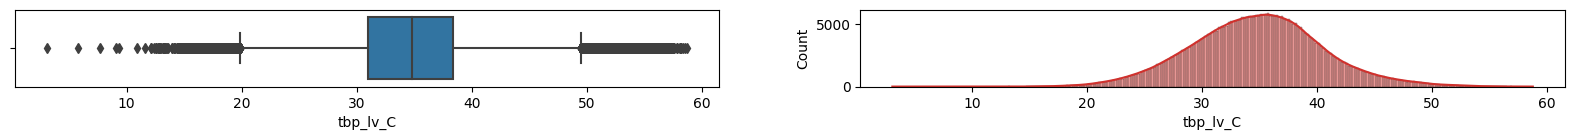

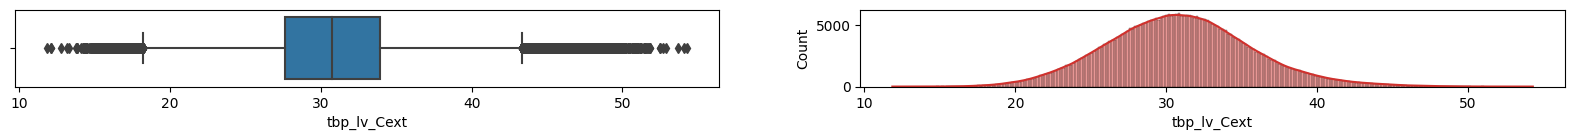

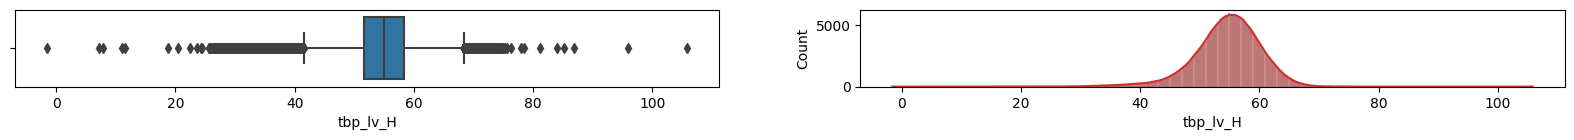

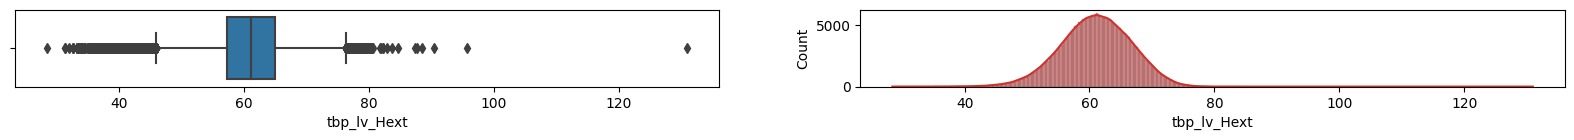

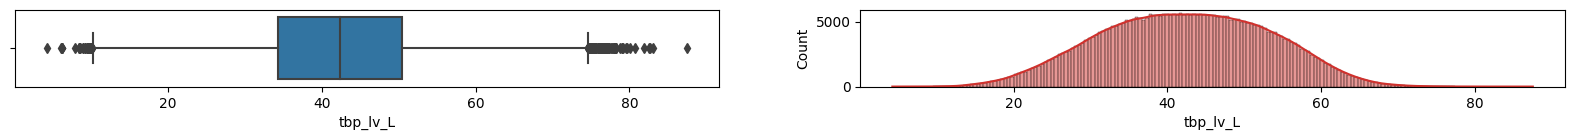

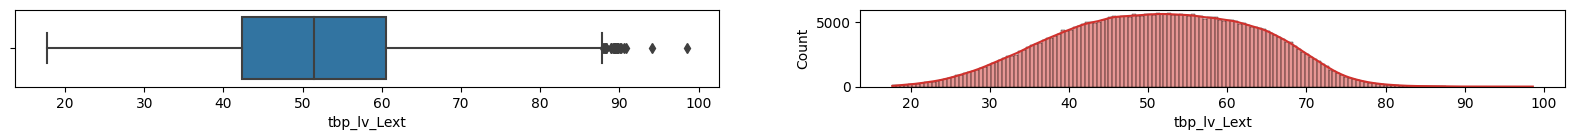

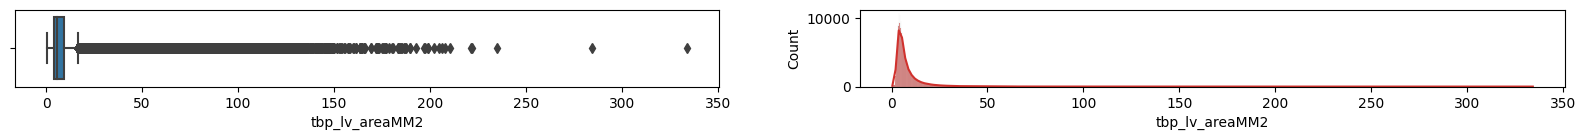

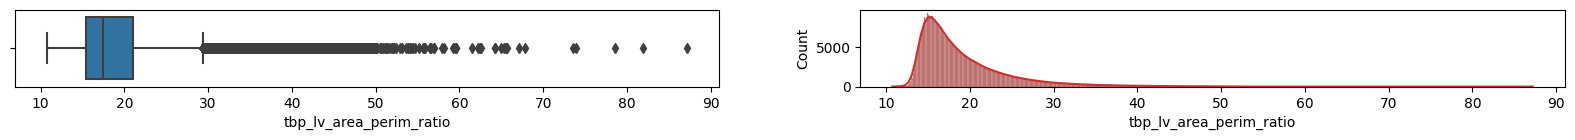

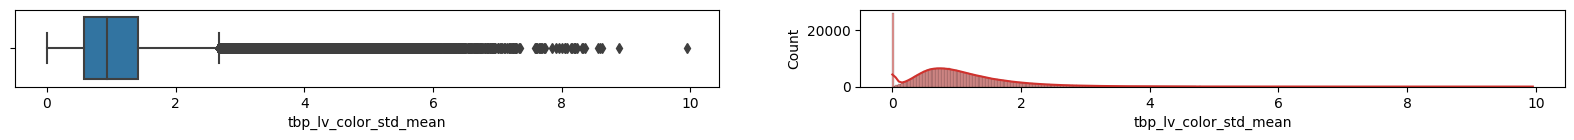

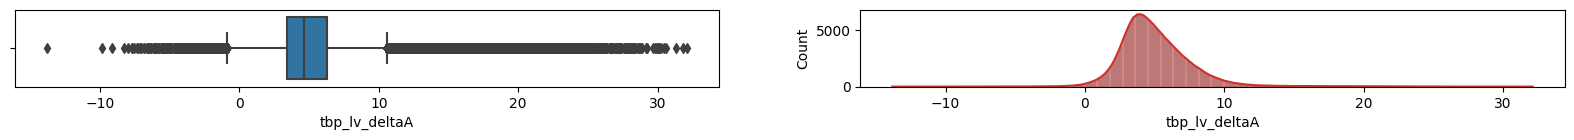

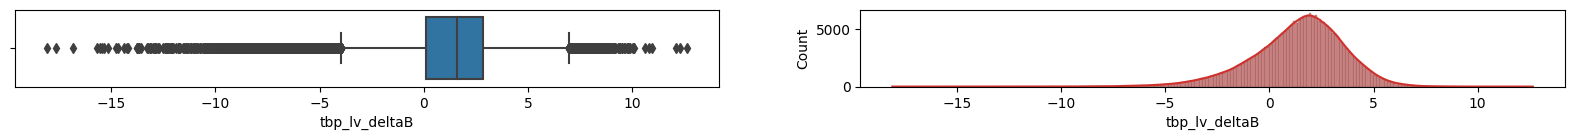

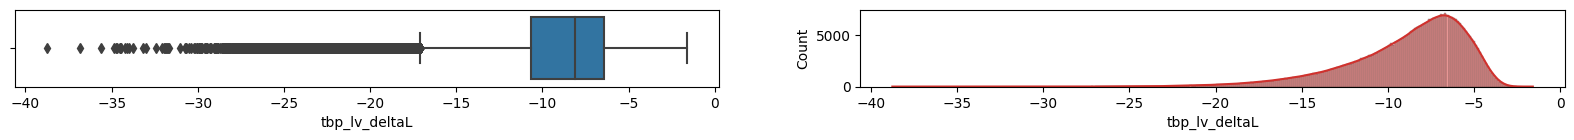

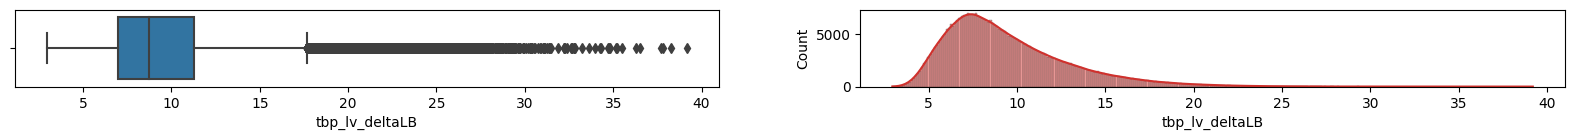

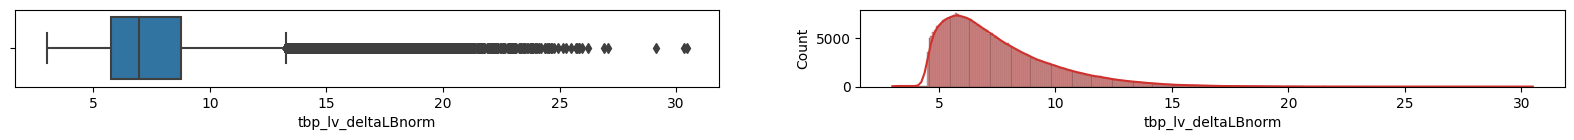

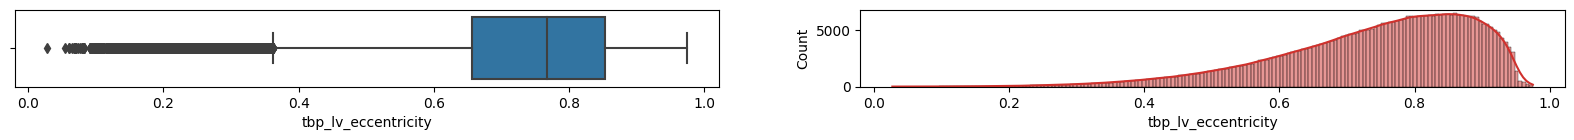

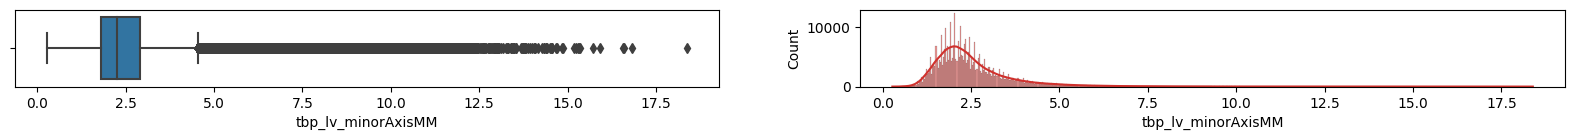

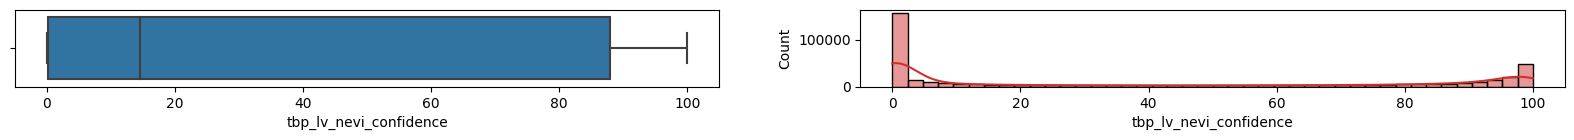

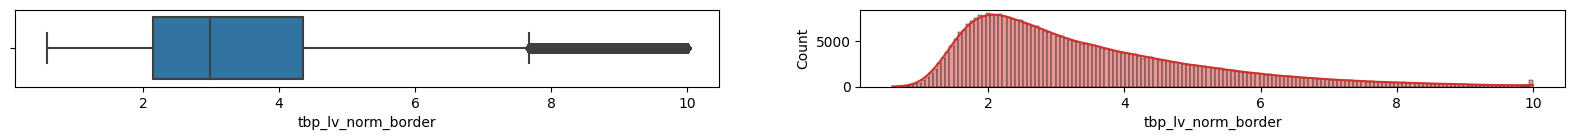

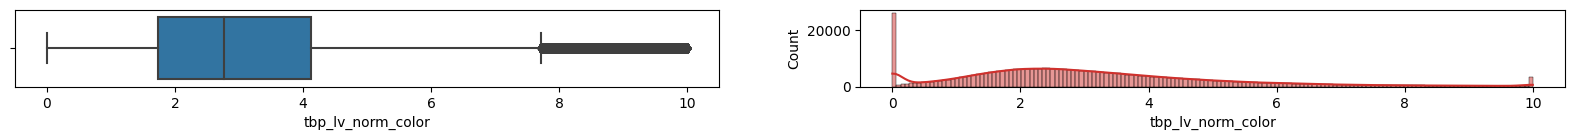

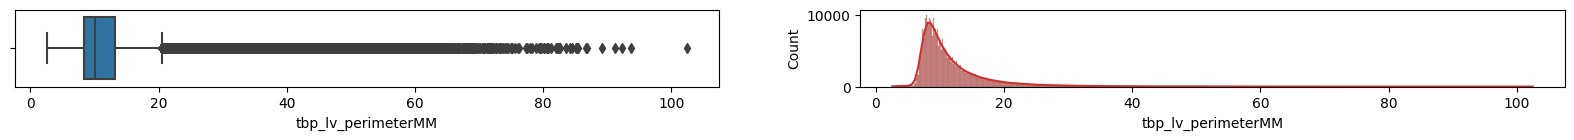

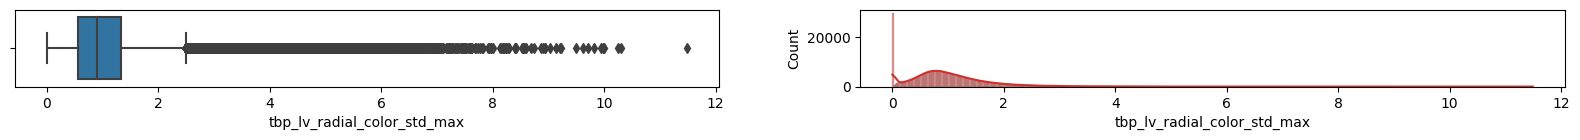

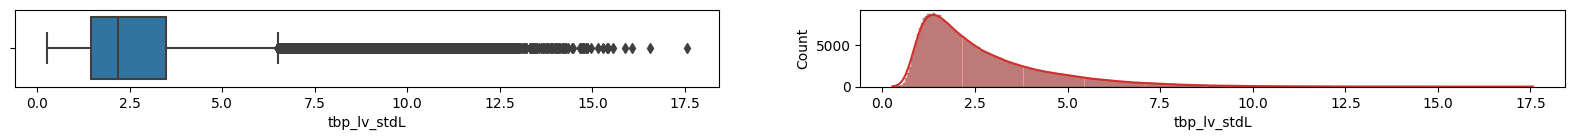

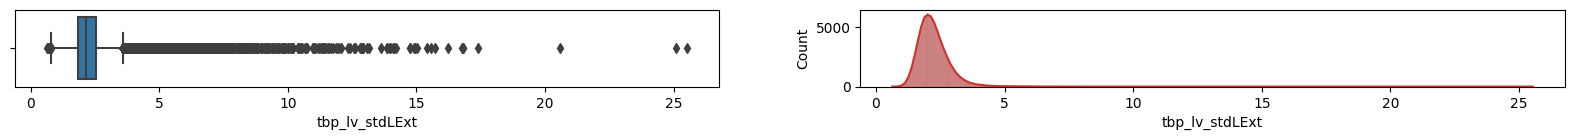

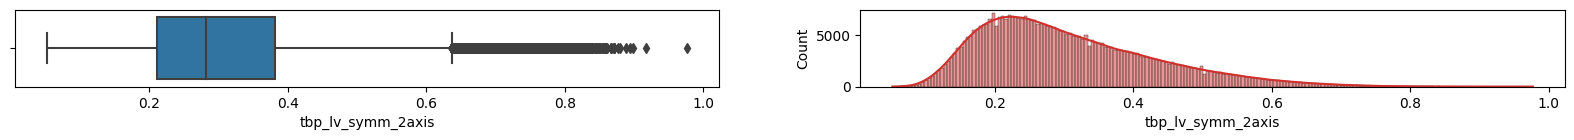

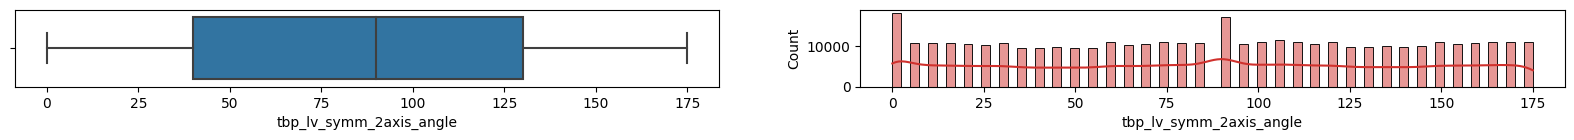

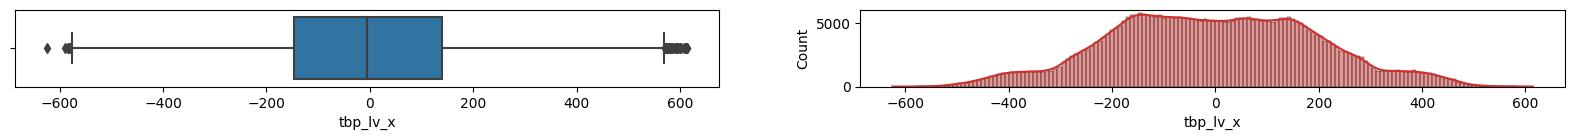

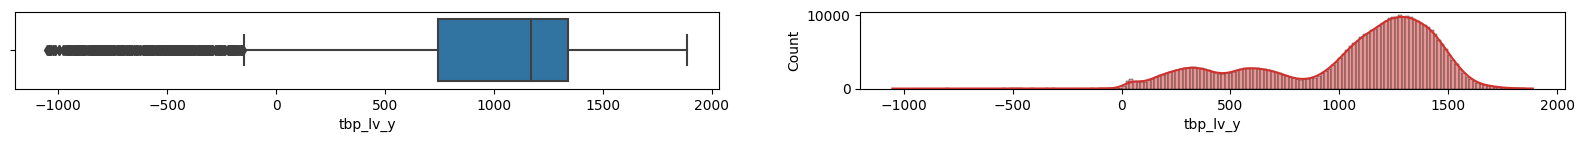

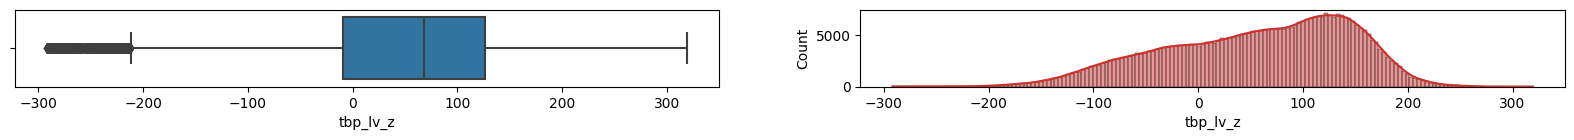

In [17]:
if ENABLE['eda'] == 1:
    
    num_features = list(df_dropped_train.columns[(df_dropped_train.dtypes != object) & (df_dropped_train.dtypes != 'category')])
    num_features.remove('target')
    def plot_num(df, feature, label=''):
        feature = label + feature
        fig = plt.figure(figsize=(20,1))
        axes = fig.add_subplot(121)    
        sns.boxplot(data=df, x=feature, ax=axes)    
        axes = fig.add_subplot(122)
        sns.histplot(data=df, x=feature, ax=axes, color='#D0312D', kde=True)
        fig.set_size_inches(20, 1)
        plt.show()

    def plot_num_comp(df1, df2, feature, label1='', label2=''):
        feature1 = label1 + feature
        feature2 = label2 + feature
        fig = plt.figure(figsize=(20,2))
        axes = fig.add_subplot(141)    
        sns.boxplot(data=df1, x=feature1, ax=axes)    
        axes = fig.add_subplot(142)
        sns.histplot(data=df1, x=feature1, ax=axes, color='#D0312D', kde=True)
        axes = fig.add_subplot(143)    
        sns.boxplot(data=df2, x=feature2, ax=axes)    
        axes = fig.add_subplot(144)
        sns.histplot(data=df2, x=feature2, ax=axes, color='green', kde=True)
        fig.set_size_inches(20, 2)
        plt.show()

    for idx, column in enumerate(num_features):
        plot_num(df_dropped_train, column)

Some data distributions, such as "tbp_lv_eccentricity" and tbp_lv_perimeterMM, are right and left skewed. Transformation may be needed. Other features do not need to be transformed, for example, coordinates, or even features with negative values.

In [18]:
if ENABLE['eda'] == 1:
    
    # This function anlyzes, for each feature, different transforms for correcting skeweness and returns
    # a dataframe with the results. Ideally a data distribution should have a skewness score close to 0.
    # Good skeness score are around +- 0.5
    def analyze_skewness(df):

        # Obtain the list of the column names
        num_features = list(df.columns[(df.dtypes != object) & (df.dtypes != 'category')])
        if 'target' in df:
            num_features.remove('target')

        # Define the number of rows and columns
        num_rows = len(num_features)
        columns = ['Feature', 'ORIG', 'LOG', 'SQR', 'RSQR']

        # Initialize the dataframe with zeros
        df_stats = pd.DataFrame(np.zeros((num_rows, len(columns))), columns=columns)

        # Loop over features
        for idx, feature in enumerate(num_features):

            tr_log = ColumnTransformer(transformers=[("log", FunctionTransformer(np.log1p), [feature])])
            tr_sqr = ColumnTransformer(transformers=[("sqr", FunctionTransformer(np.square), [feature])])    
            tr_sqrt = ColumnTransformer(transformers=[("sqrt", FunctionTransformer(np.sqrt), [feature])])

            df_log = pd.DataFrame(tr_log.fit_transform(df))
            df_sqr = pd.DataFrame(tr_sqr.fit_transform(df))
            df_sqrt = pd.DataFrame(tr_sqrt.fit_transform(df))

            df_stats.iloc[idx,0] = feature
            df_stats.iloc[idx,1] = round(df[feature].skew(),1)
            df_stats.iloc[idx,2] = round(df_log.skew()[0],1)
            df_stats.iloc[idx,3] = round(df_sqr.skew()[0],1)
            df_stats.iloc[idx,4] = round(df_sqrt.skew()[0],1)

        return pd.DataFrame(df_stats).set_index('Feature')
    
    # Display metrics!
    display(analyze_skewness(df_dropped_train))

,ORIG,LOG,SQR,RSQR
Feature,,,,
age_approx,-0.3,-1.1,0.3,-0.6
clin_size_long_diam_mm,2.8,1.4,6.6,1.9
tbp_tile_type,-0.9,-0.9,-0.9,-0.9
tbp_lv_A,0.6,-0.2,1.6,0.1
tbp_lv_Aext,0.4,-0.3,1.3,0.0
tbp_lv_B,0.2,-0.5,0.8,-0.1
tbp_lv_Bext,0.3,-0.2,0.9,0.1
tbp_lv_C,0.1,-0.5,0.6,-0.2
tbp_lv_Cext,0.2,-0.3,0.7,-0.0


## Generating Dataframe After EDA

In [19]:
if ENABLE['eda'] == 1:
    
    # According to the above table, some features may require log transform and square 
    # transform to correct skewness. Based on an analysis of the impact of skewennes 
    # correction on KBest (f_classif), it is concluded that only feature "tbp_lv_eccentricity"
    # shall be sqr transformed to have more discriminative power.
    feature_to_be_sqrtr = ['tbp_lv_eccentricity']
    df_sqr_feature = df_dropped_train[feature_to_be_sqrtr].apply(lambda x : np.square(x))
    df_sqr_feature.columns = ['sqr_tbp_lv_eccentricity']
    
    # Merge dataframe and drop the original feature
    df_eda_train = pd.concat([df_dropped_train, df_sqr_feature], axis=1)
    df_eda_train = df_eda_train.reset_index(drop=True)
    print(f"Columns df_dropped_train: {df_dropped_train.shape[1]}")
    print(f"Columns df_eda_train: {df_eda_train.shape[1]}")
    
    # Verify that the dataframe has no NaN values
    print_NaNs(df_eda_train)
    
    #df_dropped.to_csv("train-metadata-eda.csv")
    #df_eda.to_csv("train-metadata-eda.csv", index=False)

#else:
    
    # Load dataframe with eda    
    #df_eda_train = pd.read_csv(os.path.join(ROOT_DATASET_DIR,"dataframe-eda","train-metadata-eda.csv"))

if ENABLE['profiling'] == 1:
    endt = time.time()
    eda_t = hhmmss(endt - start)
    print(f"\nEDA time: {eda_t}.")
    print(f"Total time: {hhmmss(endt - start_total)}.")

Columns df_dropped_train: 41
Columns df_eda_train: 42
The dataframe contains no NaN values

EDA time: 0:05:15.031928.
Total time: 0:05:15.031928.


# 2. Feature Engineering: Metadata

New features can be created by combining the existing ones in a meaninfull way. The new features are taken from the following notebook: https://www.kaggle.com/code/vyacheslavbolotin/isic-2024-only-tabular-data-new-features

In [20]:
if ENABLE['profiling'] == 1:
    start = time.time()

if ENABLE['fe-dt'] == 1:

    # Function to apply feature engineering
    def apply_fe(df):
        
        # Create new features
        n_rows = df.shape[0]

        new_cols = [
            'lesion_size_ratio',                 # tbp_lv_minorAxisMM      / clin_size_long_diam_mm
            'lesion_shape_index',                # tbp_lv_areaMM2          / tbp_lv_perimeterMM **2
            'hue_contrast',                      # tbp_lv_H                - tbp_lv_Hext              abs
            'luminance_contrast',                # tbp_lv_L                - tbp_lv_Lext              abs
            'lesion_color_difference',           # tbp_lv_deltaA **2       + tbp_lv_deltaB **2 + tbp_lv_deltaL **2  sqrt  
            'border_complexity',                 # tbp_lv_norm_border      + tbp_lv_symm_2axis

            'position_distance_3d',              # tbp_lv_x **2 + tbp_lv_y **2 + tbp_lv_z **2  sqrt
            'log_perimeter_to_area_ratio',       # tbp_lv_perimeterMM      / tbp_lv_areaMM2  np.log1p(x)
            'area_to_perimeter_ratio',           # tbp_lv_areaMM2          / tbp_lv_perimeterMM
            'lesion_visibility_score',           # tbp_lv_deltaLBnorm      + tbp_lv_norm_color
            'symmetry_border_consistency',       # tbp_lv_symm_2axis       * tbp_lv_norm_border
            'consistency_symmetry_border',       # tbp_lv_symm_2axis       * tbp_lv_norm_border / (tbp_lv_symm_2axis + tbp_lv_norm_border)

            'color_consistency',                 # tbp_lv_stdL             / tbp_lv_Lext
            'consistency_color',                 # tbp_lv_stdL*tbp_lv_Lext / tbp_lv_stdL + tbp_lv_Lext
            'size_age_interaction',              # clin_size_long_diam_mm  * age_approx
            'hue_color_std_interaction',         # tbp_lv_H                * tbp_lv_color_std_mean
            'lesion_severity_index',             # tbp_lv_norm_border      + tbp_lv_norm_color + tbp_lv_eccentricity / 3
            'shape_complexity_index',            # border_complexity       + lesion_shape_index
            'color_contrast_index',              # tbp_lv_deltaA + tbp_lv_deltaB + tbp_lv_deltaL + tbp_lv_deltaLBnorm

            'normalized_lesion_size',            # clin_size_long_diam_mm  / age_approx
            'mean_hue_difference',               # tbp_lv_H                + tbp_lv_Hext    / 2
            'std_dev_contrast',                  # tbp_lv_deltaA **2 + tbp_lv_deltaB **2 + tbp_lv_deltaL **2   / 3  np.sqrt
            'color_shape_composite_index',       # tbp_lv_color_std_mean   + bp_lv_area_perim_ratio + tbp_lv_symm_2axis   / 3
            'lesion_orientation_3d',             # tbp_lv_y                , tbp_lv_x  np.arctan2
            'overall_color_difference',          # tbp_lv_deltaA           + tbp_lv_deltaB + tbp_lv_deltaL   / 3

            'symmetry_perimeter_interaction',    # tbp_lv_symm_2axis       * tbp_lv_perimeterMM
            'comprehensive_lesion_index',        # tbp_lv_area_perim_ratio + tbp_lv_eccentricity + bp_lv_norm_color + tbp_lv_symm_2axis   / 4
            'color_variance_ratio',              # tbp_lv_color_std_mean   / tbp_lv_stdLExt
            'border_color_interaction',          # tbp_lv_norm_border      * tbp_lv_norm_color
            'border_color_interaction_2',
            'size_color_contrast_ratio',         # clin_size_long_diam_mm  / tbp_lv_deltaLBnorm
            'log_age_normalized_nevi_confidence',# tbp_lv_nevi_confidence  / age_approx  np.log1p(x)
            'age_normalized_nevi_confidence_2',
            'color_asymmetry_index',             # tbp_lv_symm_2axis       * tbp_lv_radial_color_std_max

            'volume_approximation_3d',           # tbp_lv_areaMM2          * sqrt(tbp_lv_x**2 + tbp_lv_y**2 + tbp_lv_z**2)
            'color_range',                       # abs(tbp_lv_L - tbp_lv_Lext) + abs(tbp_lv_A - tbp_lv_Aext) + abs(tbp_lv_B - tbp_lv_Bext)
            'shape_color_consistency',           # tbp_lv_eccentricity     * tbp_lv_color_std_mean
            'border_length_ratio',               # tbp_lv_perimeterMM      / pi * sqrt(tbp_lv_areaMM2 / pi)
            'age_size_symmetry_index',           # age_approx              * clin_size_long_diam_mm * tbp_lv_symm_2axis
            'index_age_size_symmetry',           # age_approx              * tbp_lv_areaMM2 * tbp_lv_symm_2axis
        ]

        # Initialize a DataFrame with zeros
        df_nf = pd.DataFrame(np.zeros((n_rows, len(new_cols))), columns=new_cols)

        # Calculate the new features
        df_nf['lesion_size_ratio'] = df['tbp_lv_minorAxisMM'] / (df['clin_size_long_diam_mm'] + 1e-5)
        df_nf['lesion_shape_index'] = df['tbp_lv_areaMM2'] / ((df['tbp_lv_perimeterMM'] ** 2) + 1e-5)
        df_nf['hue_contrast'] = (df['tbp_lv_H'] - df['tbp_lv_Hext']).abs()
        df_nf['luminance_contrast'] = (df['tbp_lv_L'] - df['tbp_lv_Lext']).abs()
        df_nf['lesion_color_difference'] = (df['tbp_lv_deltaA'] ** 2 + df['tbp_lv_deltaB'] ** 2 + df['tbp_lv_deltaL'] ** 2).pow(0.5)
        df_nf['border_complexity'] = df['tbp_lv_norm_border'] + df['tbp_lv_symm_2axis']

        df_nf['position_distance_3d'] = (df['tbp_lv_x'] ** 2 + df['tbp_lv_y'] ** 2 + df['tbp_lv_z'] ** 2)
        df_nf['log_perimeter_to_area_ratio'] = np.log1p(df['tbp_lv_perimeterMM'] / (df['tbp_lv_areaMM2'] + 1e-5))
        df_nf['area_to_perimeter_ratio'] = df['tbp_lv_areaMM2'] / (df['tbp_lv_perimeterMM'] + 1e-5)
        df_nf['lesion_visibility_score'] = df['tbp_lv_deltaLBnorm'] + df['tbp_lv_norm_color']
        df_nf['symmetry_border_consistency'] = df['tbp_lv_symm_2axis'] * df['tbp_lv_norm_border']
        df_nf['consistency_symmetry_border'] = df['tbp_lv_symm_2axis'] * df['tbp_lv_norm_border'] / (df['tbp_lv_symm_2axis'] + df['tbp_lv_norm_border'] + 1e-5)

        df_nf['color_consistency'] = df['tbp_lv_stdL'] / (df['tbp_lv_Lext'] + 1e-5)
        df_nf['consistency_color'] = df['tbp_lv_stdL'] * df['tbp_lv_Lext'] / (df['tbp_lv_stdL'] + df['tbp_lv_Lext'] + 1e-5)
        df_nf['size_age_interaction'] = df['clin_size_long_diam_mm'] * df['age_approx']
        df_nf['hue_color_std_interaction'] = df['tbp_lv_H'] * df['tbp_lv_color_std_mean']
        df_nf['lesion_severity_index'] = (df['tbp_lv_norm_border'] + df['tbp_lv_norm_color'] + df['tbp_lv_eccentricity']) / 3
        df_nf['shape_complexity_index'] = df_nf['border_complexity'] + df_nf['lesion_shape_index']
        df_nf['color_contrast_index'] = df['tbp_lv_deltaA'] + df['tbp_lv_deltaB'] + df['tbp_lv_deltaL'] + df['tbp_lv_deltaLBnorm']

        df_nf['normalized_lesion_size'] = df['clin_size_long_diam_mm'] / (df['age_approx'] + 1e-5)
        df_nf['mean_hue_difference'] = (df['tbp_lv_H'] + df['tbp_lv_Hext']) / 2
        df_nf['std_dev_contrast'] = ((df['tbp_lv_deltaA'] ** 2 + df['tbp_lv_deltaB'] ** 2 + df['tbp_lv_deltaL'] ** 2) / 3).pow(0.5)
        df_nf['color_shape_composite_index'] = (df['tbp_lv_color_std_mean'] + df['tbp_lv_area_perim_ratio'] + df['tbp_lv_symm_2axis']) / 3
        df_nf['lesion_orientation_3d'] = np.arctan2(df['tbp_lv_y'], df['tbp_lv_x'])
        df_nf['overall_color_difference'] = (df['tbp_lv_deltaA'] + df['tbp_lv_deltaB'] + df['tbp_lv_deltaL']) / 3

        df_nf['symmetry_perimeter_interaction'] = df['tbp_lv_symm_2axis'] * df['tbp_lv_perimeterMM']
        df_nf['comprehensive_lesion_index'] = (df['tbp_lv_area_perim_ratio'] + df['tbp_lv_eccentricity'] + df['tbp_lv_norm_color'] + df['tbp_lv_symm_2axis']) / 4
        df_nf['color_variance_ratio'] = df['tbp_lv_color_std_mean'] / (df['tbp_lv_stdLExt'] + 1e-5)
        df_nf['border_color_interaction'] = df['tbp_lv_norm_border'] * df['tbp_lv_norm_color']
        df_nf['border_color_interaction_2'] = df['tbp_lv_norm_border'] * df['tbp_lv_norm_color'] / (df['tbp_lv_norm_border'] + df['tbp_lv_norm_color'] + 1e-5)
        df_nf['size_color_contrast_ratio'] = df['clin_size_long_diam_mm'] / (df['tbp_lv_deltaLBnorm'] + 1e-5)
        df_nf['log_age_normalized_nevi_confidence'] = np.log1p(df['tbp_lv_nevi_confidence'] / (df['age_approx'] + 1e-5))
        df_nf['age_normalized_nevi_confidence_2'] = (df['clin_size_long_diam_mm']**2 + df['age_approx']**2).pow(0.5)
        df_nf['color_asymmetry_index'] = df['tbp_lv_radial_color_std_max'] * df['tbp_lv_symm_2axis']

        df_nf['volume_approximation_3d'] = df['tbp_lv_areaMM2'] * (df['tbp_lv_x']**2 + df['tbp_lv_y']**2 + df['tbp_lv_z']**2).pow(0.5)
        df_nf['color_range'] = (df['tbp_lv_L'] - df['tbp_lv_Lext']).abs() + (df['tbp_lv_A'] - df['tbp_lv_Aext']).abs() + (df['tbp_lv_B'] - df['tbp_lv_Bext']).abs()
        df_nf['shape_color_consistency'] = df['tbp_lv_eccentricity'] * df['tbp_lv_color_std_mean']
        df_nf['border_length_ratio'] = df['tbp_lv_perimeterMM'] / ((2 * np.pi * (df['tbp_lv_areaMM2'] / np.pi).pow(0.5)) + 1e-5)
        df_nf['age_size_symmetry_index'] = df['age_approx'] * df['clin_size_long_diam_mm'] * df['tbp_lv_symm_2axis']
        df_nf['index_age_size_symmetry'] = df['age_approx'] * df['tbp_lv_areaMM2'] * df['tbp_lv_symm_2axis']

        df_nf['asymmetry_ratio'] = df['tbp_lv_symm_2axis'] / (df['tbp_lv_perimeterMM'] + 1e-5)
        df_nf['asymmetry_area_ratio'] = df['tbp_lv_symm_2axis'] / (df['tbp_lv_areaMM2'] + 1e-5)
        df_nf['color_variation_intensity'] = df['tbp_lv_norm_color'] * df['tbp_lv_deltaLBnorm']
        df_nf['color_contrast_ratio'] = df['tbp_lv_deltaLBnorm'] / (df['tbp_lv_L'] + 1e-5)
        df_nf['border_density'] = df['tbp_lv_norm_border'] / (df['tbp_lv_perimeterMM'] + 1e-5)
        df_nf['area_diameter_ratio'] = df['tbp_lv_areaMM2'] / (df['clin_size_long_diam_mm']**2 + 1e-5)        
        df_nf['3d_position_angle_xz'] = np.arctan2(df['tbp_lv_z'], df['tbp_lv_x'])
        df_nf['lab_chroma'] = np.sqrt(df['tbp_lv_A']**2 + df['tbp_lv_B']**2)        
        df_nf['texture_contrast'] = df['tbp_lv_stdL'] / (df['tbp_lv_L'] + 1e-5)
        df_nf['texture_uniformity'] = 1 / (1 + df['tbp_lv_color_std_mean'])
        
        return df_nf
    
    # Execute function!
    df_fe_train = apply_fe(df_eda_train)
    
    # An remove tbp_lv_eccentricity
    df_eda_train.drop(feature_to_be_sqrtr, axis=1, inplace=True)

## Generating Dataframe after Feature Engineering

In [21]:
if ENABLE['fe-dt'] == 1:
    df_eda_fe_train = pd.concat([df_eda_train,                 # original features = [df_dropped_train, df_dropped_log_sqr_corr_train]
                                 df_fe_train],                 # new features from the orignal ones                                  
                                axis=1)
    df_eda_fe_train = df_eda_fe_train.reset_index(drop=True)

    print(f"Colums df_eda_train: {df_eda_train.shape[1]}")
    print(f"Colums df_eda_train + fe: {df_eda_fe_train.shape[1]}")
    
    # Create (and fit) imputers for the rest of columns
    numericals = df_eda_fe_train.select_dtypes(include=['number']).columns.tolist()
    categoricals = [col for col in df_eda_fe_train.columns if col not in numericals]
    numericals.remove('target') # To be removed
    numericals.remove('age_approx') # To be removed, already KNN imputed
    categoricals.remove('sex') # To be removed, already KNN imputed
    IMPUTER_NUMERICALS = SimpleImputer(strategy='median')
    IMPUTER_NUMERICALS.fit(df_eda_fe_train[numericals])
    IMPUTER_CATEGORICALS = SimpleImputer(strategy='most_frequent')
    IMPUTER_CATEGORICALS.fit(df_eda_fe_train[categoricals])    
    
    # Verify that the dataframe has no NaN values
    print_NaNs(df_eda_fe_train)
    
    # Save the dataframe after feature engineering
    #df_eda_fe_train.to_csv("train-metadata-eda-fe-v3-kaggle.csv", index=False)
    
    # Save imputers
    #imputer_numerical_model = 'imputer_numericals.joblib'
    #imputer_categorical_model = 'imputer_categoricals.joblib'
    #dump(IMPUTER_NUMERICALS, imputer_numerical_model)
    #dump(IMPUTER_CATEGORICALS, imputer_categorical_model)
        
if ENABLE['profiling'] == 1:
    endt = time.time()
    fe_t = hhmmss(endt - start)
    print(f"\nFE time: {fe_t}.")
    print(f"Total time: {hhmmss(endt - start_total)}.")

Colums df_eda_train: 41
Colums df_eda_train + fe: 91
The dataframe contains no NaN values

FE time: 0:00:05.455443.
Total time: 0:05:20.521343.


# 3. Training the Convolutional Neural Network: ResNet152V2

## Reading and Processing Functions

In [22]:
if ENABLE['profiling'] == 1:
    start = time.time()

# Function to get all image files belonging to image_list in a given directory
def get_folder_files(folder_path, image_list):  

    files = [os.path.join(folder_path, f"{image}.jpg") for image in image_list]
    return files

# Function to create and write images for each file path in given directories.
def create_and_write_img(file_paths, file_ids, file_targets, save_dir_0, save_dir_1, desc=None):

    # Iterate over each file while also displaying a progress bar using tqdm
    for file_path, file_id, file_target, in tqdm(zip(file_paths, file_ids, file_targets), ascii=True, total=len(file_ids), desc=desc, leave=True):

        # Build the new file name
        new_name = file_id + ".jpg"

        # Build the image path
        if file_target == 0:
            dst_img_path = os.path.join(save_dir_0, new_name)
        else:
            dst_img_path = os.path.join(save_dir_1, new_name)

        # Copy the file from the original location to the destination directory
        shutil.copy(file_path, dst_img_path)

    return

def rsync_images(src_dirs, dest_dir):

    # Execute rsync for each source directory
    for src_dir in src_dirs:
        command = ['rsync', '-a', f'{src_dir}/', dest_dir]
        result = subprocess.run(command, capture_output=True, text=True)

        # Print output and errors for debugging
        print(result.stdout)
        if result.stderr:
            print(f"Error: {result.stderr}")
    return

# Function to count files in a directory
def count_files(target_dir):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

## Preparing Images for CNN-based Feature Extraction

In [23]:
if ENABLE['train-cnn'] == 1:
    
    # Read the dataset
    IMAGE_PATH=os.path.join(ROOT_DATASET_DIR,"isic-2024-challenge","train-image","image")

    CASE_FOLDERS = os.listdir(IMAGE_PATH)
    ROOT_IMAGE_DIR =  os.path.join("images")
    ROOT_TRAIN_DIR_0 = os.path.join(ROOT_IMAGE_DIR, "train", "0")
    ROOT_TRAIN_DIR_1 = os.path.join(ROOT_IMAGE_DIR, "train", "1")    
    ROOT_ALL_DIR = os.path.join(ROOT_IMAGE_DIR,"all","10")

    # Create directories if not already present
    os.makedirs(ROOT_TRAIN_DIR_0, exist_ok=True)
    os.makedirs(ROOT_TRAIN_DIR_1, exist_ok=True)    
    os.makedirs(ROOT_ALL_DIR, exist_ok=True)
        
    # Train-test split
    X_train = df_eda_fe_train.drop(['target'], axis=1)
    y_train = df_eda_fe_train['target']

In [24]:
if ENABLE['train-cnn'] == 1:
    
    # Copy benign cases to folder "0" and malign cases to folder "1"
    ids_train = X_train.isic_id.to_list()
    files_train = get_folder_files(folder_path=IMAGE_PATH, image_list=ids_train)

    create_and_write_img(file_paths=files_train,
                         file_ids=ids_train,
                         file_targets=y_train,                     
                         save_dir_0=ROOT_TRAIN_DIR_0,
                         save_dir_1=ROOT_TRAIN_DIR_1,
                         desc=f"Train :: {IMAGE_PATH}")

Train :: /kaggle/input/isic-2024-challenge/train-image/image: 100%|##########| 395303/395303 [54:20<00:00, 121.25it/s] 


In [25]:
if ENABLE['train-cnn'] == 1:
    # Copy all training images into a single directory for inference
    src_dirs = [ROOT_TRAIN_DIR_0, ROOT_TRAIN_DIR_1]
    dest_dir = ROOT_ALL_DIR
    rsync_images(src_dirs, dest_dir)

    # And check out that the copies to directores are successfull 
    all_dirs = src_dirs.copy()
    all_dirs.append(dest_dir)
    total = 0
    subtotal = 0
    for directory in all_dirs:
        file_count = count_files(directory)
        print(f"{directory} contains {file_count} files")
        if directory in src_dirs:
            subtotal = subtotal + file_count
        total = total + file_count
    print(f"Total files in the train directory: {subtotal}")
    print(f"Total files in {IMAGE_PATH}: {total}")
    print(f"Total cases in the dataframe: {df_eda_fe_train.shape[0]}")



images/train/0 contains 394910 files
images/train/1 contains 393 files
images/all/10 contains 395303 files
Total files in the train directory: 395303
Total files in /kaggle/input/isic-2024-challenge/train-image/image: 790606
Total cases in the dataframe: 395303


## Evaluation Functions

In [26]:
# ploting model loss during training, created by Daniel:
# https://medium.com/geekculture/how-to-plot-model-loss-while-training-in-tensorflow-9fa1a1875a5
class plot_learning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []


    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)

            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

## Image Processing Functions

In [27]:
# Function for custom normalization
def custom_normalization(image):
    image = image / 255.0
    mean = tf.constant(MEAN, dtype=image.dtype)
    std = tf.constant(STD, dtype=image.dtype)
    image = (image - mean) / std  # Normalize each channel
    return image

# Random rotation
rotate_image = RandomRotation(factor=0.2)

# Image augmentation
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)  # Horizontal flip
    image = tf.image.random_flip_up_down(image) # Vertical flip        
    image = rotate_image(image)
    image = tf.image.random_brightness(image, max_delta=0.5)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)    
    return image, label

# Parse and process images
def parse_image(filename, label):
    filename = tf.squeeze(filename)
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IM_SIZE, IM_SIZE]) #, method=tf.image.ResizeMethod.LANCZOS3)
    image = custom_normalization(image)
    return image, label

# Generate dataset from file paths
def generate_dataset(file_paths, labels, batch_size, is_training):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)

    if is_training:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# List image paths and labels
def get_image_paths_and_labels(directory, label):
    data_dir = Path(directory)    
    all_image_paths = list(data_dir.glob('*/*.jpg'))
    all_image_paths = [str(path) for path in all_image_paths]    
    all_labels = [0 if label in str(path) else 1 for path in all_image_paths]
    return all_image_paths, all_labels

## Resampling Function

In [28]:
if ENABLE['train-cnn'] == 1:
    
    # Function to undersample the majority class and oversample the minority class
    def balance_classes(image_paths, labels, majority_size=None, minority_size=None):
        # Convert to numpy arrays for easier manipulation
        image_paths = np.array(image_paths)
        labels = np.array(labels)

        # Separate the majority and minority classes
        majority_class = image_paths[labels == 0]
        majority_labels = labels[labels == 0]

        minority_class = image_paths[labels == 1]
        minority_labels = labels[labels == 1]

        # Undersample the majority class if majority_size is specified
        if majority_size and (majority_size < len(majority_class)):
            majority_class_downsampled, majority_labels_downsampled = resample(
                majority_class,
                majority_labels,
                replace=False,  # Sample without replacement
                n_samples=majority_size,  # Number of samples after undersampling
                random_state=42  # For reproducibility
            )
        else:
            majority_class_downsampled, majority_labels_downsampled = majority_class, majority_labels

        # Oversample the minority class if minority_size is specified
        if minority_size and (minority_size > len(minority_class)):
            minority_class_upsampled, minority_labels_upsampled = resample(
                minority_class,
                minority_labels,
                replace=True,  # Sample with replacement
                n_samples=minority_size,  # Number of samples after oversampling
                random_state=42  # For reproducibility
            )
        else:
            minority_class_upsampled, minority_labels_upsampled = minority_class, minority_labels

        # Combine the undersampled majority class and upsampled minority class
        balanced_image_paths = np.concatenate([majority_class_downsampled, minority_class_upsampled])
        balanced_labels = np.concatenate([majority_labels_downsampled, minority_labels_upsampled])

        return balanced_image_paths.tolist(), balanced_labels.tolist()

## Constants and Hyperparameters

In [29]:
# Define parameters related to the CNN architecture and training process
BATCH_SIZE = 64
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
IM_SIZE = 128 # assumed 128x128. Some images to be scaled.
TRAIN_TEST_SPLIT = 0.15
EPOCHS = 50
LEARN_RATE = 0.0001
REG_RATE = 0.001
NEURONS = 64
DROPOUT_RATE = 0.5
ACTIVATION = 'relu'
MODEL = 'rn152v2'
VERSION = 2

## Dataset Creation

In [30]:
if ENABLE['train-cnn'] == 1:
    
    # Split the data into training and validation sets
    if RUN_ON_KAGGLE == 1:
        all_image_paths, all_labels = get_image_paths_and_labels(os.path.join(ROOT_IMAGE_DIR,'train'), '/0')
    else:
        all_image_paths, all_labels = get_image_paths_and_labels(os.path.join(ROOT_IMAGE_DIR,'train'), '\\0')

    # Frequencies of class 1
    n_class_1 = all_labels.count(1)

    # Balance the classes by undersampling and oversampling. Both classes will be perfectly balanced.
    train_paths_balanced, train_labels_balanced = balance_classes(
        all_image_paths, 
        all_labels, 
        majority_size=n_class_1 * 10, 
        minority_size=n_class_1 * 10  
    )

    # Split the data into training and validation sets
    train_paths, validation_paths, train_labels, validation_labels = train_test_split(
        train_paths_balanced, train_labels_balanced, 
        test_size=TRAIN_TEST_SPLIT, stratify=train_labels_balanced, random_state=42
    )

    # Create datasets
    train_dataset = generate_dataset(train_paths, train_labels, BATCH_SIZE, is_training=True)
    validation_dataset = generate_dataset(validation_paths, validation_labels, BATCH_SIZE, is_training=False)    

## CNN Creation

In [31]:
def create_cnn_model(flag=0):
    
    # Load the ResNet50V2 backbone
    #base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))
    base_model = ResNet152V2(weights=None, include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))
    
    if flag == 0:
        base_model.load_weights(rn152v2_weights)
        
    # Enable backbone training
    for layer in base_model.layers:
        layer.trainable = True


    # Get the output tensor of the base ResNet50V2 model
    base_output = base_model.output

    # Apply global Average Pooling
    x = GlobalAveragePooling2D()(base_output)    

    # Add a fully connected layer with dropout and regularization to prevent overfitting
    x = Dense(NEURONS, kernel_initializer=glorot_uniform(seed=42), activation=ACTIVATION, kernel_regularizer=tf.keras.regularizers.l2(REG_RATE))(x)
    x = Dropout(DROPOUT_RATE)(x)    

    # Output layer with sigmoid activation for binary classification
    output = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile de model
    optimizer = Adam(learning_rate=LEARN_RATE)
    eval_metrics = ["accuracy"] #AUC(from_logits=False), SpecificityAtSensitivity(sensitivity=0.8)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=eval_metrics)
    
    return model

## CNN Design and Training

**Important Note:** Training a Convolutional Neural Network (CNN) often results in non-deterministic outcomes, meaning the exact same model might not be produced each time, even with identical settings. This is particularly true when using GPUs and applying random data augmentations during training. Althougth seeding mechanisms have been implemented in this notebook to reduce randomness, complete reproducibility is not guaranteed.

To address this issue, the notebook will execute the entire training process on the GPU, but for consistent results, the output will be **overridden** by a pre-trained model generated in a previous run.

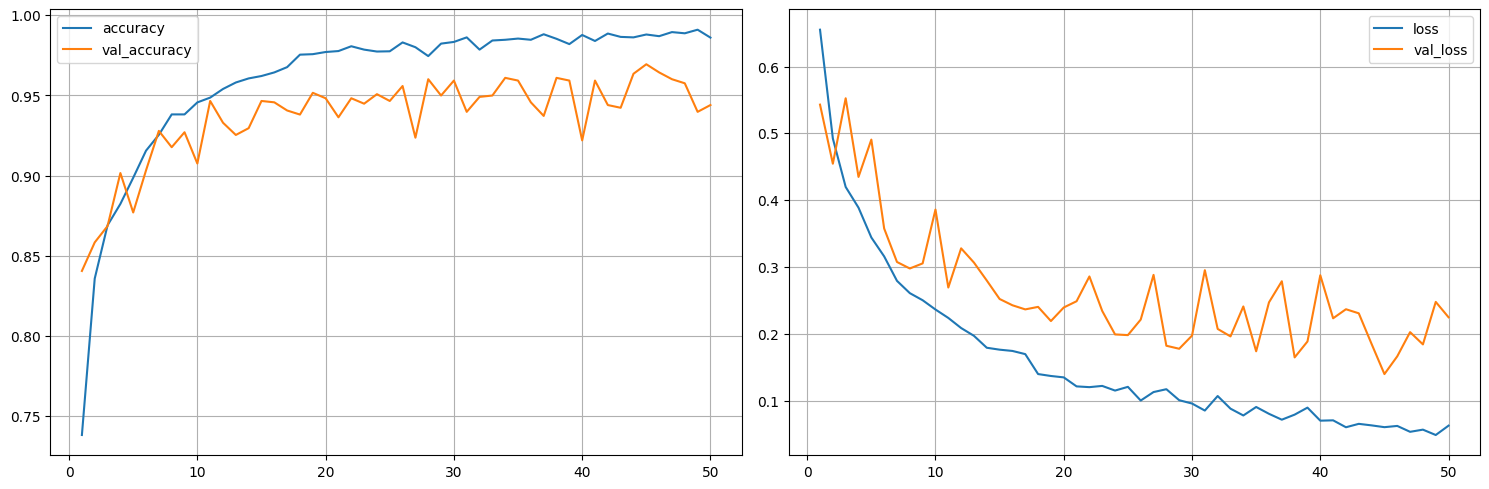

105/105 ━━━━━━━━━━━━━━━━━━━━ 54s 504ms/step - accuracy: 0.9882 - loss: 0.0550 - val_accuracy: 0.9440 - val_loss: 0.2247


In [32]:
# Create and train the CNN
if ENABLE['train-cnn'] == 1:
    
    with tf.device('/GPU:0'):
        
        # Create the model
        CNN_MODEL = create_cnn_model(flag=0)

        # Define learning rate reduction algorithm
        reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5, min_lr=1e-7)

        # Define the model checkpoint callback
        filepath=f"{MODEL}_nn{NEURONS}_lr{int(LEARN_RATE * 10000):04}_{ACTIVATION}_batch{BATCH_SIZE}_epoch{EPOCHS}_kaggle_{VERSION}.keras"
        checkpoint_callback = ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)

        # Train the model
        history = CNN_MODEL.fit(
            train_dataset,
            batch_size=BATCH_SIZE,    
            epochs=EPOCHS,
            verbose=1,
            validation_data=validation_dataset,    
            callbacks=[plot_learning(), checkpoint_callback] #reduce_lr_callback
        )

In [33]:
# Save the weights
if ENABLE['train-cnn'] == 1:
    
#   CNN_MODEL = load_model(filepath)
#   CNN_MODEL.save_weights(f"{MODEL}_nn{NEURONS}_lr{int(LEARN_RATE * 10000):04}_{ACTIVATION}_batch{BATCH_SIZE}_epoch{EPOCHS}_kaggle_weights_{VERSION}.weights.h5")
    
    # Remove the currently generated checkpoint if exists
    if os.path.exists(filepath):
        os.remove(filepath) 

In [34]:
# Load a prevously trained model for the sake of reproducibility and consistency in the next sections 
if ENABLE['train-cnn'] == 1:
    if ENABLE['load-cnn-bk'] == 1:
        CNN_MODEL = create_cnn_model(flag=1)
        CNN_MODEL.load_weights(cnn_weights)
else:
    CNN_MODEL = create_cnn_model(flag=1)
    CNN_MODEL.load_weights(cnn_weights)
             
if ENABLE['profiling'] == 1:
    endt = time.time()
    cnn_t = hhmmss(endt - start)
    print(f"\nCNN training time: {cnn_t}.")
    print(f"Total time: {hhmmss(endt - start_total)}.")


CNN training time: 1:47:47.004502.
Total time: 1:53:07.538085.


# 4. Training Machine Learning Classification Models

## Evaluation Functions

In [35]:
if ENABLE['profiling'] == 1:
    start = time.time()

# This function calculates the partial AUC score
def partial_auc_score(y_actual, y_scores, tpr_threshold=0.80):
    max_fpr = 1 - tpr_threshold

    # create numpy arrays
    y_actual = np.asarray(y_actual)
    y_scores = np.asarray(y_scores)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_actual, y_scores)

    # Find the index where fpr exceeds max_fpr
    stop_index = np.searchsorted(fpr, max_fpr, side='right')

    if stop_index < len(fpr):
        # Interpolate to find the TPR at max_fpr
        fpr_interp_points = [fpr[stop_index - 1], fpr[stop_index]]
        tpr_interp_points = [tpr[stop_index - 1], tpr[stop_index]]
        tpr = np.append(tpr[:stop_index], np.interp(max_fpr, fpr_interp_points, tpr_interp_points))
        fpr = np.append(fpr[:stop_index], max_fpr)
    else:
        tpr = np.append(tpr, 1.0)
        fpr = np.append(fpr, max_fpr)

    # Calculate partial AUC
    partial_auc_value = auc(fpr, tpr)

    return partial_auc_value

# This fuction calculates the average partial AUC score across all validation folds.
def cross_val_partial_auc_score(X, y, model, n_splits):

     # Setup cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    pauc_scores = []
    cont = 1
    for train_idx, val_idx in skf.split(X, y):

        print(f'Processing fold {cont} of {n_splits}... ', end='', flush=True)
        
        # Create the folds
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
                
        # Train the model
        model.fit(X_train_fold, y_train_fold)
    
        # Predict on the validation set
        preds = model.predict_proba(X_val_fold)[:,1]
   
        # Calculate partical AUC and store it
        pauc = partial_auc_score(y_val_fold, preds)
        pauc_scores.append(pauc)

        print(f'pAUC: {pauc}', flush=True)
        
        cont += 1
    
    # Return the average
    return np.mean(pauc_scores)

## Preparing the Final Features

In [36]:
# Metadata
if ENABLE['train-ml'] == 1:
    # For consistency, make sure that the categorical features are labeled as categorical
    df_eda_fe_train['anatom_site_general'] = pd.Categorical(df_eda_fe_train['anatom_site_general'])
    df_eda_fe_train['tbp_lv_location'] = pd.Categorical(df_eda_fe_train['tbp_lv_location'])
    df_eda_fe_train['tbp_lv_location_simple'] = pd.Categorical(df_eda_fe_train['tbp_lv_location_simple'])
    df_eda_fe_train['sex'] = pd.Categorical(df_eda_fe_train['sex'])

In [37]:
# Images

# Note: In order to train the final ML pipeline, a previously generated cross-validated CNN predition
# vector has been created during the stratifed K-fold cross-validation process to find the best CNN
# parameters. Predictions were made out-of-sample using unseen data: for each fold, a CNN model is 
# trained using 4 folds and predictions are made on the remaining fold. This apprach follows the
# principles to ensure the integrity of the final model avoiding data leakage.

if ENABLE['train-ml'] == 1:
    
    # Read the cross-validated predictions
    df_cnn_preds = pd.read_csv(crossval_preds)

    # Remove column 'target'
    df_cnn_preds.drop(columns=['target'], inplace=True)

    # Check integrity in the training data
    df_merge = pd.merge(df_eda_fe_train, df_cnn_preds, on='isic_id', how='left')

In [38]:
# X: features, y: targets (0: benign - 1: malign)
if ENABLE['train-ml'] == 1:
    
    X = df_merge.drop(['target', 'isic_id'], axis=1)
    y = df_merge['target']

    # Specify numerical and categorical features
    cnn_feature = ['crossval_cnn_preds']
    numerical_features = X.select_dtypes(include=['number']).columns.tolist()
    categorical_features = [col for col in X.columns if col not in numerical_features]
    numerical_features.remove('crossval_cnn_preds') # To be removed for the preprocessing pipeline, this feature does not need to be scaled!
    
    print(f"Numerical features: {numerical_features} - Length: {len(numerical_features)}")
    print(f"Categorical features: {categorical_features} - Length: {len(categorical_features)}")

Numerical features: ['age_approx', 'clin_size_long_diam_mm', 'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'sqr_tbp_lv_eccentricity', 'lesion_size_ratio', 'lesion_shape_index', 'hue_contrast', 'luminance_contrast', 'lesion_color_difference', 'border_complexity', 'position_distance_3d', 'log_perimeter_to_area_ratio', 'area_to_perimeter_ratio', 'lesion_visibility_score', 'symmetry_border_consistency', 'consistency_symmetry_border', 'color_consistency', 'consistency_colo

## Dimensionality Reduction

Given the high amount of features, the K best features can be selected to fed the machine learning model.

Number of relevant numerical features: 78

                               Score        P-Value
Feature                                            
crossval_cnn_preds       4437.105741   0.000000e+00
tbp_lv_areaMM2            820.761461  2.531843e-180
tbp_lv_H                  810.064722  5.299787e-178
volume_approximation_3d   757.924108  1.092496e-166
mean_hue_difference       685.574310  5.521188e-151
...                              ...            ...
texture_uniformity          8.768705   3.064612e-03
border_density              7.883024   4.990341e-03
area_diameter_ratio         7.833223   5.129703e-03
tbp_lv_L                    6.699025   9.646915e-03
3d_position_angle_xz        4.017118   4.504131e-02

[78 rows x 2 columns]


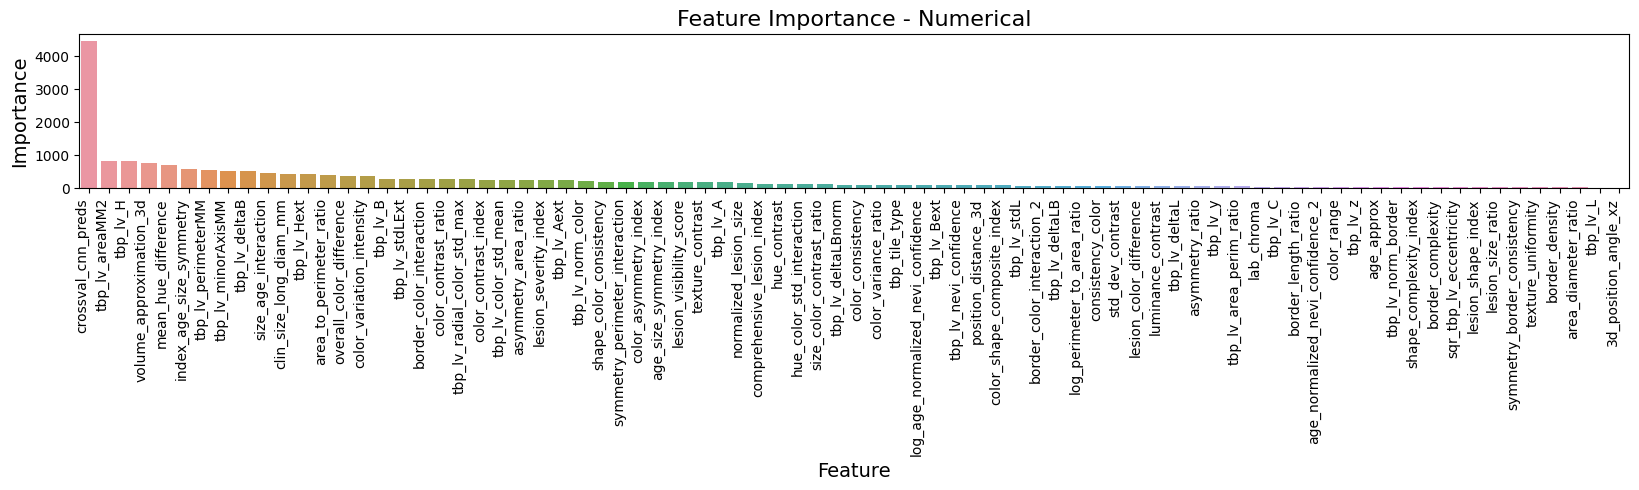

Number of relevant categorical features: 8

                                              Score       P-Value
Feature                                                          
anatom_site_general_head/neck            364.361682  3.161229e-81
tbp_lv_location_Right Leg - Upper         15.614025  7.767632e-05
tbp_lv_location_simple_Right Leg           8.605018  3.352381e-03
anatom_site_general_lower extremity        8.463089  3.624258e-03
tbp_lv_location_Left Leg                   8.314718  3.932510e-03
tbp_lv_location_Torso Front Bottom Half    5.201509  2.256728e-02
tbp_lv_location_Torso Back Middle Third    4.221756  3.990885e-02
tbp_lv_location_Left Leg - Upper           3.866920  4.924681e-02


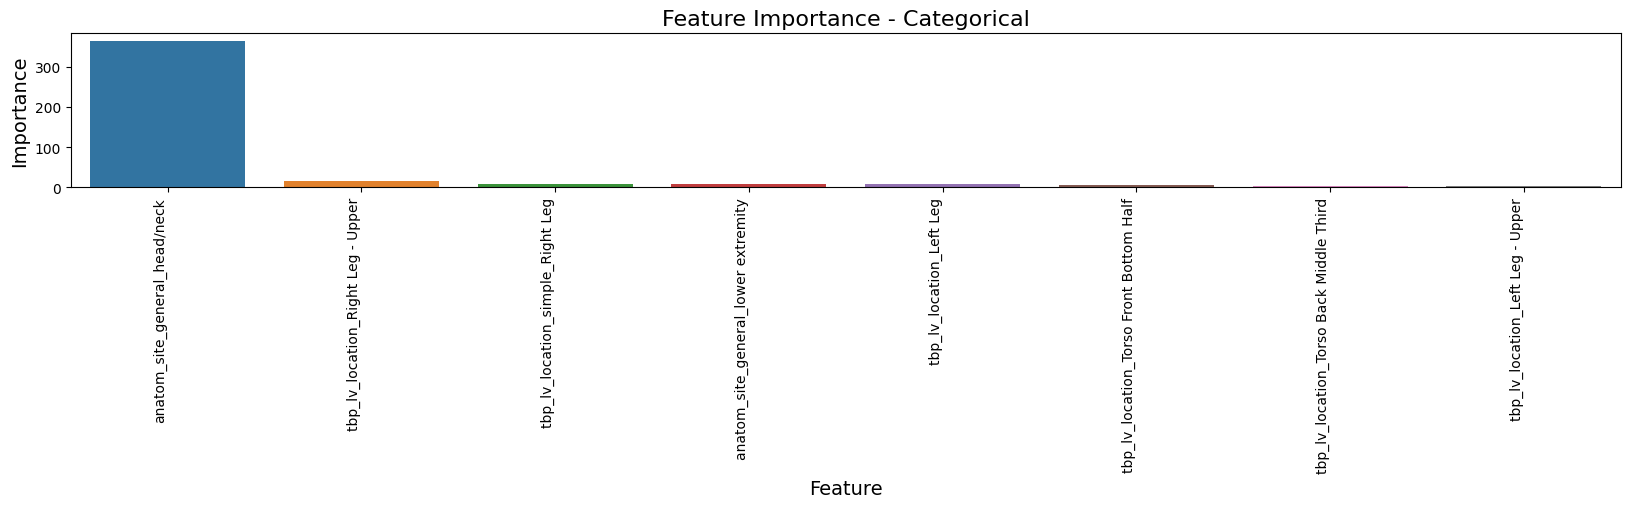

In [39]:
if ENABLE['train-ml'] == 1: 
    def analyze_kbest(X, y, threshold):
    
        # Identify numerical and categorical features
        numerical_features = X.select_dtypes(include=['number']).columns.tolist()
        categorical_features = [col for col in X.columns if col not in numerical_features]
       
        # Use SelectKBest (f_classif) for numerical features
        Kbest_numerical = SelectKBest(score_func=f_classif, k='all')
        Kbest_numerical.fit(X[numerical_features], y)
       
        # Extract feature scores and p-values
        scores = Kbest_numerical.scores_
        pvalues = Kbest_numerical.pvalues_
       
        # Create a DataFrame to save feature names, scores, and p-values
        feature_scores = pd.DataFrame({
            'Feature': numerical_features,
            'Score': scores,
            'P-Value': pvalues
        })
       
        # Sort features by 'Score'
        best_feature_scores = feature_scores[feature_scores['P-Value'] < threshold]
        sorted_features = best_feature_scores.sort_values(by='Score', ascending=False)
       
        # Display the sorted features
        kbest_num = sorted_features.shape[0]
        print(f"Number of relevant numerical features: {kbest_num}\n")
        print(sorted_features.set_index('Feature'))
       
        #best_numerical_features = sorted_features.index.tolist()
       
        # Plot feature importance
        fig = plt.figure(figsize=(20,2))
        ax = fig.add_subplot()
        sns.barplot(x='Feature', y='Score', data=sorted_features, ax=ax)
        plt.xticks(rotation=90, ha='right')
        plt.title('Feature Importance - Numerical', fontsize=16)
        plt.xlabel('Feature', fontsize=14)
        plt.ylabel('Importance', fontsize=14)
        #plt.tight_layout()
        plt.show()
       
        # Use SelectKBest (chi2) for categorical features
    
        # Build a pipeline
        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)
            ],
            remainder='drop'
        )
       
        pipeline = Pipeline(steps=[
            ('onehot', preprocessor),
            ('kbest', SelectKBest(score_func=chi2, k='all'))
        ])
       
        cat_transformed = pipeline.fit_transform(X, y)
        Kbest_categorical = pipeline.named_steps['kbest']
       
        # Extract feature scores and p-values
        scores = Kbest_categorical.scores_
        pvalues = Kbest_categorical.pvalues_
       
        # Extract feature names after one-hot encoding
        one_hot_feature_names = pipeline.named_steps['onehot'].transformers_[0][1].get_feature_names_out(categorical_features)
       
        # Create a DataFrame to hold feature names, scores, and p-values
        feature_scores = pd.DataFrame({
            'Feature': one_hot_feature_names,
            'Score': scores,
            'P-Value': pvalues
        })
       
        # Sort features by their scores
        best_feature_scores = feature_scores[feature_scores['P-Value'] < threshold]
        sorted_features = best_feature_scores.sort_values(by='Score', ascending=False)
       
        # Display the sorted features
        kbest_cat = sorted_features.shape[0]
        print(f"Number of relevant categorical features: {kbest_cat}\n")
        print(sorted_features.set_index('Feature'))
    
         # Plot feature importance
        fig = plt.figure(figsize=(20,2))
        ax = fig.add_subplot()
        sns.barplot(x='Feature', y='Score', data=sorted_features, ax=ax)
        plt.xticks(rotation=90, ha='right')
        plt.title('Feature Importance - Categorical', fontsize=16)
        plt.xlabel('Feature', fontsize=14)
        plt.ylabel('Importance', fontsize=14)
        #plt.tight_layout()
        plt.show()
       
        #best_categorical_features = sorted_features.index.tolist()
       
        return kbest_num, kbest_cat
    
    KBEST_NUM, KBEST_CAT = analyze_kbest(X, y, 0.05) # 5% threshold or P-Value

## Preprocessing Pipeline

In [40]:
# Disable Kbest: slightly better results are achieved with all the features
if ENABLE['train-ml'] == 1: 
    # Different paths for numerical and categorical features
    pipe_num = Pipeline([
        ('scaler', RobustScaler()),
        ###('kbest', SelectKBest(score_func=f_classif, k=KBEST_NUM)),   
    ])
    
    pipe_cat = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
        ###('kbest', SelectKBest(score_func=chi2, k=KBEST_CAT)),    
    ])
    
    preprocessing = ColumnTransformer(transformers=[
        ('cnn_pred', 'passthrough', cnn_feature),
        ('numerical', pipe_num, numerical_features),
        ('categorical',pipe_cat, categorical_features)
    ])

## Model Architecture

The final model architecture consists of a series of advanced ensemble learning models and a final soft-voting classifier:
* Random Forest: bagging
* XGBoost: boosting
* LightGBM: boosting
* CatBoost: boosting
* GBM: boosting

After serveral trials it was found that the pipeline with the best trade off between computation time and qualiyt is the one that includes XGBoost, LightGBM, and GBM.

In [41]:
# Random Forest

# From Optuna:
param_rf = {
    'random_state':      42,
    'bootstrap':         True,
    'n_jobs':            -1,
    'n_estimators':      423,
    'max_features':      'sqrt',
    'criterion':         'entropy', 
    'max_depth':         16,
    'min_samples_split': 7,
    'min_samples_leaf':  11,    
    'class_weight':      'balanced_subsample',
}

model_rf = ImbPipeline([    
    ('preprocessing', preprocessing),
    ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
    ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
    ('RF',  BalancedRandomForestClassifier(**param_rf))
])

# XGBoost

# From Optuna:  
param_xgb = {
    'random_state':       42,    
    'n_estimators':       314,
    'learning_rate':      0.01598029895340339,
    'reg_lambda':         8.74156143244379,
    'alpha':              0.5488140237894854,
    'max_depth':          12,
    'subsample':          0.6055836154106841,
    'colsample_bytree':   0.8065993145017623,
    'colsample_bylevel':  0.42877642423818046,
    'scale_pos_weight':   8.137601492474564,
    'eval_metric':        'logloss',
    'enable_categorical': True
}

model_xgb = ImbPipeline([    
        ('preprocessing', preprocessing),
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
        ('RF',  XGBClassifier(**param_xgb))
])

# LightGBM

# From Optuna: 
param_lgb = {
    'random_state':     42,
    'objective':        'binary',
    'boosting_type':    'gbdt',
    'verbosity':        -1, 
    'n_estimators':     468,
    'lambda_l1':        0.06494901485897991,
    'lambda_l2':        0.004124742250363338,
    'learning_rate':    0.008048319396269177,
    'max_depth':        36,
    'num_leaves':       44,
    'colsample_bytree': 0.4093518762615021,
    'colsample_bynode': 0.9949755355913121,
    'bagging_fraction': 0.9561339359254485,
    'bagging_freq':     1,
    'min_data_in_leaf': 5,
    'scale_pos_weight': 1.6403781913121338
}

model_lgb = ImbPipeline([    
        ('preprocessing', preprocessing),
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
        ('LGB',  LGBMClassifier(**param_lgb))
])

# CatBoost

# From Optuna:  
param_cb = {
    'random_state':     42,
    'loss_function':    'Logloss',
    'verbose':          False,
    'n_estimators':     202,
    'max_depth':        14,
    'learning_rate':    0.06369630886157396,
    'scale_pos_weight': 1.4986002433238226,
    'l2_leaf_reg':      9.957793406416098,
    'subsample':        0.2993503168795559,
    'min_data_in_leaf': 14
}

model_cb = ImbPipeline([    
        ('preprocessing', preprocessing),
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
        ('CB',  CatBoostClassifier(**param_cb))
])

# GBM

# From Optuna:
param_gbm = {
    'random_state':      42,
    'n_estimators':      409,
    'learning_rate':     0.013344792621668246,
    'max_depth':         6,
    'min_samples_split': 13,
    'min_samples_leaf':  12,
    'max_features':      'sqrt',
    'subsample':         0.5247402463247972
}

model_gbm = ImbPipeline([    
        ('preprocessing', preprocessing),
        ('undersample', RandomUnderSampler(sampling_strategy={0: 40000}, random_state=42)),
        ('oversample', SMOTE(sampling_strategy={1: 4000}, random_state=42)),
        ('GBM', GradientBoostingClassifier(**param_gbm))
])

# Final stacking architecture

# Build the soft-voting ensemble archicecture
estimators=[
        ###('RF',  model_rf),
        ('XGB', model_xgb),
        ('LGB', model_lgb),
        ###('CB',  model_cb),
        ('GBM', model_gbm)
]

SOFT_VOTING_CLASSIF = VotingClassifier(
    estimators=estimators,
    voting='soft',
)

In [42]:
# Display the model architecture 
SOFT_VOTING_CLASSIF

VotingClassifier(estimators=[('XGB',
                              Pipeline(steps=[('preprocessing',
                                               ColumnTransformer(transformers=[('cnn_pred',
                                                                                'passthrough',
                                                                                ['crossval_cnn_preds']),
                                                                               ('numerical',
                                                                                Pipeline(steps=[('scaler',
                                                                                                 RobustScaler())]),
                                                                                ['age_approx',
                                                                                 'clin_size_long_diam_mm',
                                                                                 'tbp_tile_type',
                                                                                 'tbp_lv_A',
                                                                                 'tbp_lv_Aext',
                                                                                 'tbp_lv_B',
                                                                                 'tbp_lv_Bext',
                                                                                 'tbp_lv_C',
                                                                                 'tbp_lv_Cext',
                                                                                 'tbp_lv_H',
                                                                                 '...
                                               RandomUnderSampler(random_state=42,
                                                                  sampling_strategy={0: 40000})),
                                              ('oversample',
                                               SMOTE(random_state=42,
                                                     sampling_strategy={1: 4000})),
                                              ('GBM',
                                               GradientBoostingClassifier(learning_rate=0.013344792621668246,
                                                                          max_depth=6,
                                                                          max_features='sqrt',
                                                                          min_samples_leaf=12,
                                                                          min_samples_split=13,
                                                                          n_estimators=409,
                                                                          random_state=42,
                                                                          subsample=0.5247402463247972))]))],
                 voting='soft')

## Compute the Average Partial AUC Score

In [43]:
# Average partial AUC across across the folds
if ENABLE['train-ml'] == 1: 
    pauc_sft = cross_val_partial_auc_score(X, y, SOFT_VOTING_CLASSIF, n_splits=5)
    print(f"CV Partial AUC Score: {pauc_sft}")

Processing fold 1 of 5... pAUC: 0.15252076342342377
Processing fold 2 of 5... pAUC: 0.1722259742565923
Processing fold 3 of 5... pAUC: 0.16668431743300585
Processing fold 4 of 5... pAUC: 0.16788950289874546
Processing fold 5 of 5... pAUC: 0.16728400953414244
CV Partial AUC Score: 0.16532091350918196


## Final Training

In [44]:
# Using the whole training dataset
if ENABLE['train-ml'] == 1: 
    print("Fitting... ", end='')
    SOFT_VOTING_CLASSIF.fit(X, y)
    #model_lgb.fit(X, y)
    print("finished.")
    #print("And saving...")
    #dump(SOFT_VOTING_CLASSIF, 'soft_voting_classif_xgb_lgb_gbm_v2.joblib')
    #dump(model_lgb, 'model_lgb_withcnn.joblib')
    #print("finished.")
else:
    SOFT_VOTING_CLASSIF = load(ml_model)
    
if ENABLE['profiling'] == 1:
    endt = time.time()
    ml_t = hhmmss(endt - start)
    print(f"\nML model training time: {ml_t}.")
    print(f"Total time: {hhmmss(endt - start_total)}.")

Fitting... finished.

ML model training time: 0:09:01.469996.
Total time: 2:02:09.021938.


# 5. Inference

## Metadata: Data Cleaning and Feature Engineering

In [45]:
if ENABLE['profiling'] == 1:
    start = time.time()

# Read the test metadata file 
if ENABLE['inference'] == 1:

    # Read the dataset
    meta_file = os.path.join(ROOT_DATASET_DIR,"isic-2024-challenge","test-metadata.csv")
    hdf5_file =os.path.join(ROOT_DATASET_DIR,"isic-2024-challenge","test-image.hdf5")
    df_raw = pd.read_csv(meta_file)
    
    print(f"Number of samples in the test dataframe: {df_raw.shape[0]}")
    print(f"Number of features in the test dataframe: {df_raw.shape[1]}")
    print("\n")

    # Drop redundant columns or columns that are not in the training set
    train_columns = df_dropped_train.columns
    df_dropped = df_raw[train_columns.intersection(df_raw.columns)]   
          
    # Replace NaN values
    if df_dropped['age_approx'].isnull().any():
        IMPUTER_AGE = load(imputer_age_model)
        age_approx_reshaped = df_dropped[['age_approx']]
        df_dropped['age_approx'] = IMPUTER_AGE.transform(age_approx_reshaped)
        
    df_dropped['sex'] = df_dropped['sex'].apply(lambda x: 0 if x == 'male' else 1 if x == 'female' else np.NaN)        
    if df_dropped['sex'].isnull().any():
        IMPUTER_SEX = load(imputer_sex_model)
        sex_reshaped = df_dropped[['sex']]
        df_dropped['sex'] = IMPUTER_SEX.transform(sex_reshaped)
        
    # Dropp duplicates
    df_dropped.drop_duplicates(inplace=True)  
    
    # Determine how many samples have been removed
    print(f"Number of samples before removing NaNs and duplicates: {df_raw.shape[0]}")
    print(f"Number of samples after removing NaNs and duplicates:  {df_dropped.shape[0]}")
    print(f"Data reduccion in percentage: {np.round(100 * (df_dropped.shape[0] - df_raw.shape[0]) / df_raw.shape[0], 1)}%")
    print("\n")

Number of samples in the test dataframe: 3
Number of features in the test dataframe: 44


Number of samples before removing NaNs and duplicates: 3
Number of samples after removing NaNs and duplicates:  3
Data reduccion in percentage: 0.0%




In [46]:
# Convert data types
if ENABLE['inference'] == 1:
    
    # Convert: tdb_tile_type -> 0: white, 1: XP
    df_dropped['tbp_tile_type'] = df_dropped['tbp_tile_type'].apply(lambda x: 0 if x == '3D: white' else 1)
    df_dropped['tbp_tile_type'] = df_dropped['tbp_tile_type'].astype(int)

    # Convert: anatom_site_general, tbp_lv_location, tbp_lv_location_simple into categorical, and sex
    df_dropped['anatom_site_general'] = pd.Categorical(df_dropped['anatom_site_general'])
    df_dropped['tbp_lv_location'] = pd.Categorical(df_dropped['tbp_lv_location'])
    df_dropped['tbp_lv_location_simple'] = pd.Categorical(df_dropped['tbp_lv_location_simple'])
    df_dropped['sex'] = pd.Categorical(df_dropped['sex'])

In [47]:
# Correct skewness and concatenate with the original feature dataframe
if ENABLE['inference'] == 1:
    
    # Sqrt transform "tbp_lv_eccentricity"
    feature_to_be_sqrtr = ['tbp_lv_eccentricity']
    df_sqr_feature = df_dropped[feature_to_be_sqrtr].apply(lambda x : np.square(x))
    df_sqr_feature.columns = ['sqr_tbp_lv_eccentricity']
    
    # Concatenate
    df_eda = pd.concat([df_dropped, df_sqr_feature], axis=1)
    df_eda = df_eda.reset_index(drop=True)
    print(f"Colums df_dropped_train: {df_dropped.shape[1]}")
    print(f"Colums df_eda_train: {df_eda.shape[1]}")
    
    # Verify that the dataframe has no NaN values
    print_NaNs(df_eda)

Colums df_dropped_train: 40
Colums df_eda_train: 41
The dataframe contains no NaN values


In [48]:
# Apply feature engineering (new features based on metadata) and skewness correction
if ENABLE['inference'] == 1:
    
    # Feature engineering
    df_fe = apply_fe(df_eda)
    
    # And remove tbp_lv_eccentricity
    df_eda.drop(feature_to_be_sqrtr, axis=1, inplace=True)

In [49]:
# Concatenate the partial dataframes
if ENABLE['inference'] == 1:
    df_eda_fe = pd.concat([df_eda,   # original features = [df_dropped, df_dropped_log_sqr_corr]
                           df_fe],   # new features from the orignal ones 
                           axis=1)
    df_eda_fe = df_eda_fe.reset_index(drop=True)
    
    # Apply imputing if some operations have resulted in NaN values
    IMPUTER_NUMERICALS = load(imputer_numerical_model)
    IMPUTER_CATEGORICALS = load(imputer_categorical_model)
    numericals = df_eda_fe.select_dtypes(include=['number']).columns.tolist()
    categoricals = [col for col in df_eda_fe.columns if col not in numericals]
    numericals.remove('age_approx') # Already analyzed
    categoricals.remove('sex') # Already analyzed
    df_eda_fe[numericals] = IMPUTER_NUMERICALS.transform(df_eda_fe[numericals])
    df_eda_fe[categoricals] = IMPUTER_CATEGORICALS.transform(df_eda_fe[categoricals])

    print(f"Colums df_eda: {df_eda.shape[1]}")
    print(f"Colums df_eda + fe (log + sqr + sqrt): {df_eda_fe.shape[1]}")
    
    # Verify that the dataframe has no NaN values
    print_NaNs(df_eda_fe)

Colums df_eda: 40
Colums df_eda + fe (log + sqr + sqrt): 90
The dataframe contains no NaN values


## Images: Data Preparation

In [50]:
# Class image dataloader: from https://www.kaggle.com/code/masayukeeeee/how-to-extract-images-from-hdf5-file
@dataclass
# dataloader
class DataLoader():
    def __init__(self, meta_file, hdf5_file):
        self.meta_file = meta_file
        self.hdf5_file = hdf5_file

    def load_meta(self):
        setattr(self, f"meta", pd.read_csv(self.meta_file))
            
    def load_hdf5(self):        
        setattr(self, f"hdf5", h5py.File(self.hdf5_file, 'r'))

    def __getitem__(self, isic_id):
        if self.hdf5.get(isic_id):
            return self.hdf5[isic_id][()]
        else:
            raise ValueError(f"ISIC_ID {isic_id} is not found in both train and test data.")                
                
dl = DataLoader(meta_file, hdf5_file)
dl.load_meta()
dl.load_hdf5()

In [51]:
# Store the images in a test directory and create the dataset input to the CNN
if ENABLE['inference'] == 1:
    
    # Read the dataset
    ROOT_IMAGE_DIR =  os.path.join("images")    
    ROOT_INFERENCE_DIR = os.path.join(ROOT_IMAGE_DIR,'inference')
    ROOT_INFERENCE_LABEL_DIR = os.path.join(ROOT_IMAGE_DIR,'inference','10')

    # Create the inference directory if not already present        
    os.makedirs(ROOT_INFERENCE_DIR, exist_ok=True)
    os.makedirs(ROOT_INFERENCE_LABEL_DIR, exist_ok=True)
    
    def save_images_from_hdf5(dl, output_dir): #, split='train'): #split='test'):
        
        # Iterate through the images in the dataset
        for i in range(len(dl.meta)):
            isic_id = dl.meta.iloc[i].isic_id
            img_bytes = dl.__getitem__(isic_id)
            img = Image.open(BytesIO(img_bytes))

            # Save the image to the specified directory
            img.save(os.path.join(output_dir, f"{isic_id}.jpg"))
    
    # Call the function to save images
    save_images_from_hdf5(dl, ROOT_INFERENCE_LABEL_DIR)

    # Create the test dataset
    if RUN_ON_KAGGLE == 1:
        test_image_paths, test_labels = get_image_paths_and_labels(ROOT_INFERENCE_DIR, '/10') # Just dummy labels
    else:
        test_image_paths, test_labels = get_image_paths_and_labels(ROOT_INFERENCE_DIR, '\\10') # Just dummy labels

    # Check integrity in the test data to match the image list in the image folder and in the dataframe
    
    # Create a dataframe with image names from test_image_paths
    test_image_names = pd.DataFrame({'test_image_paths': test_image_paths, 'test_labels': test_labels})
    test_image_names['isic_id'] = test_image_names['test_image_paths'].apply(lambda x: re.search(r'(ISIC_\d+)', x).group(1))

    # Perform an inner merge with the metadata dataframe. The order of the left keys (df_eda_fe) is preserved.
    df_merge = pd.merge(df_eda_fe, test_image_names, on='isic_id', how='inner')
    
    # Extract the paths and (dummy) labels and reordered metadata
    test_image_paths = df_merge['test_image_paths'].tolist()
    test_labels = df_merge['test_labels'].tolist()

    # Generate the dataset, the input of the CNN
    test_image_dataset = generate_dataset(test_image_paths, test_labels, BATCH_SIZE, is_training=False)

## Make Predictions

In [52]:
# Verify consistency in the test feature set
if ENABLE['inference'] == 1:

    def verify_train_test_feature_match(X_train, X_test):
        # Separate numerical and categorical features for both train and test sets
        numerical_features_train = X_train.select_dtypes(include=['number']).columns.tolist()
        categorical_features_train = [col for col in X_train.columns if col not in numerical_features_train]

        numerical_features_test = X_test.select_dtypes(include=['number']).columns.tolist()
        categorical_features_test = [col for col in X_test.columns if col not in numerical_features_test]

        # Check for differences in numerical features
        missing_numerical_in_test = set(numerical_features_train) - set(numerical_features_test)
        extra_numerical_in_test = set(numerical_features_test) - set(numerical_features_train)

        # Check for differences in categorical features
        missing_categorical_in_test = set(categorical_features_train) - set(categorical_features_test)
        extra_categorical_in_test = set(categorical_features_test) - set(categorical_features_train)

        # Check if both numerical and categorical features are identical in both sets
        if not missing_numerical_in_test and not extra_numerical_in_test and not missing_categorical_in_test and not extra_categorical_in_test:
            print("Feature check passed: Both train and test sets have the same features.")
            print(f"Numerical features: {numerical_features_test} - Length: {len(numerical_features_test)}")
            print(f"Categorical features: {categorical_features_test} - Length: {len(categorical_features_test)}")
            
        else:
            # Print out the results
            print("Feature check failed: Train and test sets have different features:")

            # Printing function
            def print_result(description, result_set):
                if result_set:
                    print(f"- {description}:", result_set)
                else:
                    print(f"- {description}: None")

            print_result("Numerical features in train but not in test", missing_numerical_in_test)
            print_result("Numerical features in test but not in train", extra_numerical_in_test)
            print_result("Categorical features in train but not in test", missing_categorical_in_test)
            print_result("Categorical features in test but not in train", extra_categorical_in_test)

In [53]:
if ENABLE['inference'] == 1:

    # Make predictions using the CNN
    cnn_test_preds = CNN_MODEL.predict(test_image_dataset)
    df_cnn_test_preds = pd.DataFrame(cnn_test_preds, columns=['crossval_cnn_preds'])

    # Make final predictions
    X_test = pd.concat([df_eda_fe.drop(['isic_id'], axis=1), df_cnn_test_preds], axis=1)
    
    verify_train_test_feature_match(X, X_test)
        
    # Print X_test stats    
    print(f"Shape of the test set: {X_test.shape}")
    
    y_test = SOFT_VOTING_CLASSIF.predict_proba(X_test)[:, 1]
    
    # Create the dataframe
    df_submission = pd.DataFrame({'isic_id': df_merge['isic_id'].tolist(), 'target': y_test.tolist()})

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Feature check passed: Both train and test sets have the same features.
Numerical features: ['age_approx', 'clin_size_long_diam_mm', 'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'sqr_tbp_lv_eccentricity', 'lesion_size_ratio', 'lesion_shape_index', 'hue_contrast', 'luminance_contrast', 'lesion_color_difference', 'border_complexity', 'position_distance_3d', 'log_perimeter_to_area_ratio', 'area_to_perimeter_ratio', 'lesion_visibility

In [54]:
# Print profiling
if ENABLE['profiling'] == 1:
    endt = time.time()
    inf_t = hhmmss(endt - start)
    
    # Print profiling results
    print("\nProfiling Results:")
    print(f"{'Phase':<25}{'Time (HH:MM:SS)'}")
    print("-" * 40)
    print(f"{'EDA':<25}{eda_t}")
    print(f"{'Feature Engineering':<25}{fe_t}")
    print(f"{'CNN Training':<25}{cnn_t}")
    print(f"{'ML Model Training':<25}{ml_t}")
    print(f"{'Inference':<25}{inf_t}")
    print(f"{'Total':<25}{hhmmss(endt - start_total)}")


Profiling Results:
Phase                    Time (HH:MM:SS)
----------------------------------------
EDA                      0:05:15.031928
Feature Engineering      0:00:05.455443
CNN Training             1:47:47.004502
ML Model Training        0:09:01.469996
Inference                0:00:10.847361
Total                    2:02:19.880427


In [55]:
df_submission.head()

,isic_id,target
0,ISIC_0015657,0.004900
1,ISIC_0015729,0.004347
2,ISIC_0015740,0.005379


In [56]:
# Save the output csv file
if ENABLE['inference'] == 1:
    df_submission.to_csv('submission.csv', index=False)

In [57]:
# Remove temporal folders containing images
if os.path.exists(ROOT_IMAGE_DIR):
    # Remove the folder and all its contents
    shutil.rmtree(ROOT_IMAGE_DIR)
    print(f'Folder "{ROOT_IMAGE_DIR}" and all its contents have been deleted.')
else:
    print(f'Folder "{ROOT_IMAGE_DIR}" does not exist.')

import os
# Remove joblib filesif they exist
#joblib_files = [
#    'imputer_age.joblib',
#    'imputer_sex.joblib',
#    'imputer_numericals.joblib',
#    'imputer_categoricals.joblib'
#]
#
#for file in joblib_files:
#    if os.path.exists(file):
#        os.remove(file)
#        print(f"Removed: {file}")
#    else:
#        print(f"File does not exist: {file}")

Folder "images" and all its contents have been deleted.
